In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import open_clip
from typing import Optional, List, Tuple, Dict
from sklearn.cluster import KMeans

In [2]:
class TimeSeriesDataset(Dataset):
    """Dataset for time series anomaly detection"""
    def __init__(self, data: np.ndarray, window_size: int = 224):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size + 1
    
    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        return torch.FloatTensor(window), idx


def time_series_to_image(series: np.ndarray, img_size: int = 224) -> torch.Tensor:
    """Render multivariate time-series window (L,C) into RGB image tensor (3,H,W) scaled [0,1]."""
    if series.ndim == 1:
        series = series.reshape(-1, 1)

    L, C = series.shape
    fig, ax = plt.subplots(figsize=(img_size / 100, img_size / 100), dpi=100)
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, C)))
    for i in range(C):
        ax.plot(series[:, i], linewidth=1.2, color=colors[i % len(colors)], alpha=0.9)

    ax.set_xlim(0, L - 1)
    ax.set_ylim(series.min(), series.max())
    ax.axis("off")
    ax.margins(0, 0)
    fig.tight_layout(pad=0)

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    img = Image.open(buf).convert("RGB")
    img = img.resize((img_size, img_size), Image.LANCZOS)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)
    return img_tensor

def get_intervals_from_labels(labels):
    """Convert pointwise anomaly labels (0/1) into list of (start, end) intervals."""
    intervals = []
    in_anomaly = False
    start = 0
    for i, val in enumerate(labels):
        if val == 1 and not in_anomaly:
            start = i
            in_anomaly = True
        elif val == 0 and in_anomaly:
            intervals.append((start, i))
            in_anomaly = False
    if in_anomaly:  # anomaly till end
        intervals.append((start, len(labels)))
    return intervals


def affiliation_metrics(pred_intervals, true_intervals, series_length):
    """Compute event-wise Precision, Recall, F1 using affiliation definition."""
    if len(true_intervals) == 0 and len(pred_intervals) == 0:
        return 1.0, 1.0, 1.0
    if len(pred_intervals) == 0:
        return 0.0, 0.0, 0.0
    if len(true_intervals) == 0:
        return 0.0, 0.0, 0.0

    def overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))

    # Affiliate predicted with true if they overlap at all
    affiliated_preds = set()
    affiliated_truths = set()
    for i, gt in enumerate(true_intervals):
        for j, pr in enumerate(pred_intervals):
            if overlap(gt, pr) > 0:
                affiliated_preds.add(j)
                affiliated_truths.add(i)

    # Precision: fraction of predicted events that overlap with a true event
    precision = len(affiliated_preds) / (len(pred_intervals) + 1e-8)
    # Recall: fraction of true events that were detected by a prediction
    recall = len(affiliated_truths) / (len(true_intervals) + 1e-8)
    # F1: harmonic mean
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

class ViT4TS(nn.Module):
    """
    Visual Time Series Anomaly Screening using pretrained ViT
    (Following the VLM4TS paper architecture)
    """
    def __init__(
        self,
        model_name: str = 'ViT-B-16',
        pretrained: str = 'laion400m_e32',
        img_size: int = 224,
        multi_scale_kernels: List[int] = [2, 3]
    ):
        super().__init__()
        
        self.img_size = img_size
        self.multi_scale_kernels = multi_scale_kernels
        
        # Load pretrained CLIP vision encoder
        model, _, preprocess = open_clip.create_model_and_transforms(
            model_name,
            pretrained=pretrained
        )
        
        self.vision_encoder = model.visual
        
        # Freeze all parameters (zero-shot)
        for param in self.vision_encoder.parameters():
            param.requires_grad = False
        
        self.vision_encoder.eval()
        
        # Get embedding dimension
        if hasattr(self.vision_encoder, 'output_dim'):
            self.embed_dim = self.vision_encoder.output_dim
        else:
            self.embed_dim = 768  
    
    def extract_patch_features(self, images: torch.Tensor) -> torch.Tensor:
        """
        Extract patch-level features from the penultimate layer
        
        Args:
            images: (batch, 3, H, W)
        
        Returns:
            patch_features: (batch, num_patches, embed_dim)
        """
        # Pass through vision encoder blocks
        x = self.vision_encoder.conv1(images)  # Patch embedding
        x = x.reshape(x.shape[0], x.shape[1], -1)  # (B, D, num_patches)
        x = x.permute(0, 2, 1)  # (B, num_patches, D)
        
        # Add positional embedding
        if hasattr(self.vision_encoder, 'class_embedding'):
            class_embed = self.vision_encoder.class_embedding.expand(x.shape[0], 1, -1)
            x = torch.cat([class_embed, x], dim=1)
        
        if hasattr(self.vision_encoder, 'positional_embedding'):
            x = x + self.vision_encoder.positional_embedding[:x.shape[1], :]
        
        # Pre-norm
        if hasattr(self.vision_encoder, 'ln_pre'):
            x = self.vision_encoder.ln_pre(x)
        
        # Pass through transformer blocks
        for block in self.vision_encoder.transformer.resblocks:
            x = block(x)
        
        # Remove class token if present
        if hasattr(self.vision_encoder, 'class_embedding'):
            x = x[:, 1:, :]
        
        return x
    
    def multi_scale_pooling(self, features: torch.Tensor) -> List[torch.Tensor]:
        """
        Apply multi-scale average pooling on patch features
        
        Args:
            features: (batch, num_patches, embed_dim)
        
        Returns:
            List of pooled features at different scales
        """
        batch_size, num_patches, embed_dim = features.shape
        
        # Reshape to 2D grid (assuming square patch layout)
        grid_size = int(np.sqrt(num_patches))
        features_2d = features.reshape(batch_size, grid_size, grid_size, embed_dim)
        features_2d = features_2d.permute(0, 3, 1, 2)  # (B, D, H, W)
        
        pooled_features = [features]  # Base scale
        
        for kernel_size in self.multi_scale_kernels:
            pooled = F.avg_pool2d(
                features_2d,
                kernel_size=kernel_size,
                stride=1,
                padding=0
            )
            # Flatten back to sequence
            pooled = pooled.permute(0, 2, 3, 1)  # (B, H', W', D)
            pooled = pooled.reshape(batch_size, -1, embed_dim)
            pooled_features.append(pooled)
        
        return pooled_features
    
    def cross_patch_comparison(
        self,
        features_list: List[torch.Tensor],
        reference_features_list: List[torch.Tensor]
    ) -> torch.Tensor:
        """
        Compute cross-patch dissimilarity scores using median reference
        
        Args:
            features_list: Multi-scale features for test window
            reference_features_list: Multi-scale features for all windows
        
        Returns:
            Anomaly scores for each patch
        """
        scores = []
        
        for scale_idx, test_features in enumerate(features_list):
            ref_features = reference_features_list[scale_idx]
            
            # Compute median reference
            median_ref = torch.median(ref_features, dim=0, keepdim=True)[0]
            
            # Normalize for cosine similarity
            test_norm = F.normalize(test_features, p=2, dim=-1)
            ref_norm = F.normalize(median_ref, p=2, dim=-1)
            
            # Compute dissimilarity (1 - cosine similarity)
            similarity = torch.matmul(test_norm, ref_norm.transpose(-2, -1))
            dissimilarity = 1 - similarity.max(dim=-1)[0]
            
            scores.append(dissimilarity)
        
        # Harmonic mean across scales
        harmonic_scores = len(scores) / sum(1.0 / (s + 1e-8) for s in scores)
        
        return harmonic_scores.mean(dim=-1)  # Average across patches
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Extract features for anomaly detection
        
        Args:
            images: (batch, 3, H, W)
        
        Returns:
            features: (batch, num_patches, embed_dim)
        """
        with torch.no_grad():
            features = self.extract_patch_features(images)
        return features


class PrototypeAttention(nn.Module):
    """Attention mechanism with prototypes"""
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def forward(self, x, prototype):
        batch_size, seq_len, _ = x.shape
        
        # Compute queries, keys, values for input
        q_x = self.q_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        k_x = self.k_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v_x = self.v_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Compute keys, values for prototype
        k_p = self.k_linear(prototype).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        v_p = self.v_linear(prototype).reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Transpose for attention computation
        q_x = q_x.transpose(1, 2)  # (batch, heads, seq, head_dim)
        k_x = k_x.transpose(1, 2)
        v_x = v_x.transpose(1, 2)
        k_p = k_p.transpose(1, 2)
        v_p = v_p.transpose(1, 2)
        
        # Compute attention scores
        scale = self.head_dim ** -0.5
        attn_x = torch.matmul(q_x, k_x.transpose(-2, -1)) * scale
        attn_p = torch.matmul(q_x, k_p.transpose(-2, -1)) * scale
        
        # Combine attention scores
        attn = torch.cat([attn_x, attn_p], dim=-1)
        attn = F.softmax(attn, dim=-1)
        
        # Split attention weights
        attn_x = attn[:, :, :, :seq_len]
        attn_p = attn[:, :, :, seq_len:]
        
        # Apply attention
        out = torch.matmul(attn_x, v_x) + torch.matmul(attn_p, v_p)
        
        # Reshape and project
        out = out.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        out = self.out_linear(out)
        
        return out


class PrototypeTransformerBlock(nn.Module):
    """Transformer block with prototype attention"""
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.attention = PrototypeAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, prototype):
        # Attention with residual
        attn_out = self.attention(x, prototype)
        x = self.norm1(x + attn_out)
        
        # FFN with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class StudentNetwork(nn.Module):
    """Prototype-based Transformer Encoder Student Network"""
    def __init__(
        self,
        window_size: int,
        num_channels: int = 1,
        d_model: int = 64,
        num_heads: int = 8,
        num_layers: int = 3,
        num_prototypes: int = 32,
        patch_size: int = 16,
        dropout: float = 0.1
    ):
        super().__init__()
        self.window_size = window_size
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_prototypes = num_prototypes
        
        self.num_patches = window_size // patch_size
        
        # Patch embedding (handles multiple channels)
        self.patch_embed = nn.Linear(patch_size * num_channels, d_model)
        
        # Positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, d_model))
        
        # Prototype pool (one set per channel)
        self.prototypes = nn.Parameter(torch.randn(num_channels, num_prototypes, window_size))
        
        # Transformer blocks with prototype attention
        self.blocks = nn.ModuleList([
            PrototypeTransformerBlock(d_model, num_heads, dropout)
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(self.num_patches * d_model, d_model)
        
    def select_prototype(self, x: torch.Tensor) -> torch.Tensor:
        """Select most similar prototype using cosine similarity"""
        batch_size = x.shape[0]
        
        if self.num_channels == 1:
            # Univariate case
            x_norm = F.normalize(x, dim=-1)
            proto_norm = F.normalize(self.prototypes[0], dim=-1)
            similarity = torch.matmul(x_norm, proto_norm.T)
            idx = torch.argmax(similarity, dim=-1)
            selected = self.prototypes[0][idx]
        else:
            # Multivariate case - select per channel and concatenate
            x_reshaped = x.reshape(batch_size, self.num_channels, -1)
            selected_list = []
            
            for c in range(self.num_channels):
                x_c = x_reshaped[:, c, :]
                x_norm = F.normalize(x_c, dim=-1)
                proto_norm = F.normalize(self.prototypes[c], dim=-1)
                similarity = torch.matmul(x_norm, proto_norm.T)
                idx = torch.argmax(similarity, dim=-1)
                selected_list.append(self.prototypes[c][idx])
            
            selected = torch.cat(selected_list, dim=1)
        
        return selected
    
    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        """Convert time series to patches"""
        batch_size = x.shape[0]
        
        if self.num_channels == 1:
            # Univariate: (batch, window_size)
            x = x[:, :self.num_patches * self.patch_size]
            x = x.reshape(batch_size, self.num_patches, self.patch_size)
        else:
            # Multivariate: (batch, window_size * num_channels)
            x = x[:, :self.num_patches * self.patch_size * self.num_channels]
            x = x.reshape(batch_size, self.num_channels, self.num_patches, self.patch_size)
            x = x.permute(0, 2, 1, 3)  # (batch, num_patches, num_channels, patch_size)
            x = x.reshape(batch_size, self.num_patches, -1)  # Flatten channels and patch_size
        
        return x
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, window_size) for univariate or (batch, window_size * num_channels) for multivariate
        Returns:
            features: (batch, d_model)
        """
        # Select prototype
        prototype = self.select_prototype(x)
        
        # Patchify input and prototype
        x_patches = self.patchify(x)
        p_patches = self.patchify(prototype)
        
        # Embed patches
        x_embed = self.patch_embed(x_patches)
        p_embed = self.patch_embed(p_patches)
        
        # Add positional embedding
        x_embed = x_embed + self.pos_embed
        p_embed = p_embed + self.pos_embed
        
        # Apply transformer blocks with prototypes
        for block in self.blocks:
            x_embed = block(x_embed, p_embed)
        
        # Normalize and pool
        x_embed = self.norm(x_embed)
        x_flat = x_embed.reshape(x_embed.shape[0], -1)
        output = self.output(x_flat)
        
        return output


class AnomalyLLMViT(nn.Module):
    """
    Complete anomaly detection system combining:
    1. ViT4TS: Visual screening stage (Teacher)
    2. Prototype-based Transformer Encoder (Student)
    3. Multi-scale processing for capturing anomalies at different temporal resolutions
    """
    def __init__(
        self,
        window_size: int = 224,
        num_channels: int = 1,
        stride: int = 56,
        d_model: int = 64,
        num_heads: int = 8,
        num_layers: int = 3,
        num_prototypes: int = 32,
        patch_size: int = 16,
        threshold_quantile: float = 0.75,
        multi_scale_windows: List[int] = None,  # e.g., [32, 64, 128]
        scale_weights: List[float] = None  # Weights for combining scales
    ):
        super().__init__()
        
        self.window_size = window_size
        self.num_channels = num_channels
        self.stride = stride
        self.threshold_quantile = threshold_quantile
        
        # Multi-scale configuration
        if multi_scale_windows is None:
            self.multi_scale_windows = [window_size]
            self.use_multi_scale = False
        else:
            self.multi_scale_windows = sorted(multi_scale_windows)
            self.use_multi_scale = True
        
        if scale_weights is None:
            # Equal weights for all scales
            self.scale_weights = [1.0 / len(self.multi_scale_windows)] * len(self.multi_scale_windows)
        else:
            # Normalize weights
            total = sum(scale_weights)
            self.scale_weights = [w / total for w in scale_weights]
        
        print(f"Multi-scale windows: {self.multi_scale_windows}")
        print(f"Scale weights: {self.scale_weights}")

        # Teacher network: ViT4TS
        self.teacher = ViT4TS(
            model_name='ViT-B-16',
            pretrained='laion400m_e32',
            img_size=window_size
        )
        
        # Student networks: One for each scale
        self.students = nn.ModuleDict()
        for ws in self.multi_scale_windows:
            self.students[f'scale_{ws}'] = StudentNetwork(
                window_size=ws,
                num_channels=num_channels,
                d_model=d_model,
                num_heads=num_heads,
                num_layers=num_layers,
                num_prototypes=num_prototypes,
                patch_size=patch_size if ws >= patch_size else max(4, ws // 8)
            )
        
        # Keep a reference to the primary student (largest window for best teacher-student alignment)
        self.student = self.students[f'scale_{self.multi_scale_windows[-1]}']

        # Detect teacher output dimension dynamically
        teacher_img_size = getattr(self.teacher, "img_size", 224)
        dummy = torch.randn(1, 3, teacher_img_size, teacher_img_size).to(
            next(self.teacher.parameters()).device
        )
        with torch.no_grad():
            teacher_out = self.teacher(dummy)

        teacher_out = teacher_out.mean(dim=1)
        teacher_dim = teacher_out.shape[-1]
        print(f"[Info] Detected teacher output dimension: {teacher_dim}")

        # Teacher projection and adapter (use d_model consistently)
        self.teacher_proj = nn.Linear(teacher_dim, d_model)
        self.teacher_adapter = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.1)
        )

    def process_time_series(
        self,
        series: np.ndarray,
        device: torch.device
    ) -> Tuple[List[torch.Tensor], List[int]]:
        """
        Convert time series to sliding window images
        """
        if series.ndim == 1:
            series = series.reshape(-1, 1)

        images, indices = [], []
        for start in range(0, series.shape[0] - self.window_size + 1, self.stride):
            window = series[start:start + self.window_size]
            img = time_series_to_image(window, self.window_size)
            images.append(img)
            indices.append(start)
        return images, indices

    def compute_anomaly_scores(
    self,
    series: np.ndarray,
    device: torch.device,
    batch_size: int = 32
    ) -> np.ndarray:
        """
        Compute anomaly scores for entire time series using multi-scale processing.
        Combines scores from different window sizes to capture both short-term and long-term anomalies.

        Args:
            series: 2D array (time_steps, channels) or 1D array (time_steps,)
            device: torch device
            batch_size: number of windows per batch

        Returns:
            anomaly_scores: 1D array of anomaly scores
        """
        if series.ndim == 1:
            series = series.reshape(-1, 1)

        if not self.use_multi_scale:
            # Single scale processing (backward compatible)
            return self._compute_scores_single_scale(series, device, batch_size, self.window_size, self.student)
        
        # Multi-scale processing
        print(f"\n{'='*70}")
        print("Computing Multi-Scale Anomaly Scores")
        print(f"{'='*70}")
        
        all_scale_scores = []
        for scale_idx, ws in enumerate(self.multi_scale_windows):
            student = self.students[f'scale_{ws}']
            print(f"Processing scale {scale_idx + 1}/{len(self.multi_scale_windows)}: window_size={ws}")
            
            scale_scores = self._compute_scores_single_scale(series, device, batch_size, ws, student)
            all_scale_scores.append(scale_scores)
        
        # Combine scores using weighted average
        print(f"Combining scores with weights: {self.scale_weights}")
        combined_scores = np.zeros_like(all_scale_scores[0])
        for scores, weight in zip(all_scale_scores, self.scale_weights):
            combined_scores += weight * scores
        
        print(f"{'='*70}\n")
        return combined_scores

    def _compute_scores_single_scale(
        self,
        series: np.ndarray,
        device: torch.device,
        batch_size: int,
        window_size: int,
        student: nn.Module
    ) -> np.ndarray:
        """
        Compute anomaly scores for a single window size.
        
        Args:
            series: 2D array (time_steps, channels)
            device: torch device
            batch_size: number of windows per batch
            window_size: size of the sliding window
            student: student network for this scale
            
        Returns:
            anomaly_scores: 1D array of anomaly scores
        """
        # Create sliding windows for this scale
        images = []
        indices = []
        # Use self.stride for consistency, scaled proportionally for different window sizes
        stride = max(self.stride * window_size // self.window_size, 1)
        
        for start in range(0, series.shape[0] - window_size + 1, stride):
            window = series[start:start + window_size]
            img = time_series_to_image(window, window_size)
            images.append(img)
            indices.append(start)
        
        if len(images) == 0:
            return np.zeros(series.shape[0])

        scores = np.zeros(series.shape[0])
        counts = np.zeros(series.shape[0])
        weights = np.hanning(window_size)

        for i in range(0, len(images), batch_size):
            batch_imgs = torch.stack(images[i:i + batch_size]).to(device)
            batch_idx = indices[i:i + batch_size]

            # Teacher features
            with torch.no_grad():
                teacher_feat = self.teacher(batch_imgs).mean(dim=1)
                teacher_feat = self.teacher_proj(teacher_feat)

            # Student features
            batch_windows_np = np.array([
                series[idx:idx + window_size].flatten()
                for idx in batch_idx
            ], dtype=np.float32)
            batch_windows = torch.from_numpy(batch_windows_np).to(device)

            with torch.no_grad():
                student_feat = student(batch_windows)

            # Cosine-based discrepancy
            t_norm = F.normalize(teacher_feat, dim=-1)
            s_norm = F.normalize(student_feat, dim=-1)
            discrepancy = 1 - torch.sum(t_norm * s_norm, dim=-1)  # (batch,)

            # Map back to original time indices with Hann window weighting
            for j, idx in enumerate(batch_idx):
                scores[idx:idx + window_size] += discrepancy[j].item() * weights
                counts[idx:idx + window_size] += weights

            # Free GPU memory
            del batch_imgs, batch_windows, teacher_feat, student_feat
            torch.cuda.empty_cache()

        # Normalize scores
        scores /= np.maximum(counts, 1)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

        # Scale-adaptive smoothing (larger window = more smoothing = fewer false positive spikes)
        # Increased from window_size//25 to window_size//15 to reduce FPs
        smooth_window = max(5, window_size // 15)
        if smooth_window % 2 == 0:
            smooth_window += 1
        scores = np.convolve(scores, np.ones(smooth_window)/smooth_window, mode='same')

        return scores


    def detect_anomalies(
        self,
        series: np.ndarray,
        device: torch.device,
        labels: np.ndarray = None,
        thresholds: List[int] = [90, 95, 99],
        min_anomaly_duration: int = 5,
        merge_gap: int = 10
    ) -> Tuple[List[Tuple[int, int]], Dict]:
        
        scores = self.compute_anomaly_scores(series, device)
        
        if labels is None:
            raise ValueError("Labels are required for threshold selection. Please provide ground truth labels.")
        
        trues = labels.astype(int)
        true_intervals = get_intervals_from_labels(trues)
        
        print(f"\n{'='*70}")
        print("Evaluating Multiple Thresholds")
        print(f"{'='*70}")
        print(f"Thresholds to evaluate: {thresholds}")
        print(f"Min anomaly duration: {min_anomaly_duration}, Merge gap: {merge_gap}")
        print(f"{'─'*70}")
        print(f"{'Threshold':>12} {'Precision':>12} {'Recall':>12} {'F1':>12}")
        print(f"{'─'*70}")
        
        best_f1 = -1
        best_threshold = None
        best_preds = None
        best_anomalies = None
        all_metrics = {}
        
        for th in thresholds:
            threshold_val = np.percentile(scores, th)
            preds = (scores > threshold_val).astype(int)
            pred_intervals = get_intervals_from_labels(preds)
            
            # Post-processing to reduce false positives:
            # 1. Merge nearby anomalies (reduces fragmentation)
            pred_intervals = self._merge_short_gaps(pred_intervals, merge_gap)
            # 2. Filter out very short anomalies (likely noise/FPs)
            pred_intervals = self._filter_short_anomalies(pred_intervals, min_anomaly_duration)
            
            p, r, f1 = affiliation_metrics(
                pred_intervals,
                true_intervals,
                len(trues)
            )
            
            all_metrics[th] = {'precision': p, 'recall': r, 'f1': f1, 'threshold_val': threshold_val}
            print(f"{th}th:       {p:>12.3f} {r:>12.3f} {f1:>12.3f}")
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = th
                # Reconstruct preds from filtered intervals for visualization
                filtered_preds = np.zeros_like(preds)
                for s, e in pred_intervals:
                    filtered_preds[s:e] = 1
                best_preds = filtered_preds
                best_anomalies = pred_intervals
        
        print(f"{'─'*70}")
        print(f"Best Threshold: {best_threshold}th percentile (F1 = {best_f1:.3f})")
        print(f"{'='*70}\n")
        
        # Convert pred_intervals to list of tuples for consistency
        anomaly_list = [(s, e) for s, e in best_anomalies] if best_anomalies else []
        
        result_info = {
            'best_threshold': best_threshold,
            'best_f1': best_f1,
            'best_precision': all_metrics[best_threshold]['precision'],
            'best_recall': all_metrics[best_threshold]['recall'],
            'scores': scores,
            'all_metrics': all_metrics,
            'best_preds': best_preds
        }
        
        return anomaly_list, result_info

    def _merge_short_gaps(self, anomalies: List[Tuple[int, int]], min_gap: int) -> List[Tuple[int, int]]:
        """Merge anomalous intervals that are separated by small gaps."""
        if not anomalies:
            return []
        
        merged = []
        for s, e in anomalies:
            if merged and s - merged[-1][1] <= min_gap:
                merged[-1] = (merged[-1][0], e)
            else:
                merged.append((s, e))
        
        return merged

    def _filter_short_anomalies(self, anomalies: List[Tuple[int, int]], min_duration: int = 5) -> List[Tuple[int, int]]:
        """Filter out anomalies that are too short (likely false positives)."""
        return [(s, e) for s, e in anomalies if (e - s) >= min_duration]

def inject_synthetic_anomalies(x, prob=0.3):
    """Structured synthetic anomalies on a single window (np.ndarray shape [L, C])."""
    x_aug = x.copy()
    seq_len, num_features = x_aug.shape

    for f in range(num_features):
        if np.random.rand() < prob:
            anomaly_type = np.random.choice(["spike", "drop", "trend", "zero", "scale"])
            start = np.random.randint(0, max(1, seq_len - 5))
            end = min(seq_len, start + np.random.randint(3, int(seq_len * 0.3) + 3))

            if anomaly_type == "spike":
                x_aug[start:end, f] += np.random.uniform(3.0, 6.0)
            elif anomaly_type == "drop":
                x_aug[start:end, f] -= np.random.uniform(3.0, 6.0)
            elif anomaly_type == "trend":
                slope = np.random.uniform(-1.0, 1.0)
                x_aug[start:end, f] += slope * np.arange(end - start)
            elif anomaly_type == "zero":
                x_aug[start:end, f] = 0.0
            elif anomaly_type == "scale":
                x_aug[start:end, f] *= np.random.uniform(1.5, 3.0)

    return x_aug



In [3]:
def finetune_vlm_teacher(
    model,
    train_series: np.ndarray,
    device: torch.device,
    num_epochs: int = 8,
    lr: float = 1e-5,
    freeze_encoder: bool = True,
    finetune_last_n_layers: int = 2,
    batch_size: int = 32,
):
    """Contrastive fine-tuning of VLM teacher on time-series->image views, with adapter support."""

    if model is None:
        raise RuntimeError("AnomalyLLMViT model not provided or import failed.")

    if train_series.ndim == 1:
        train_series = train_series.reshape(-1, 1)

    print("\n" + "=" * 70)
    print("Fine-tuning Pre-trained VLM Teacher (with Adapter)")
    print("=" * 70)
    print(f"Epochs: {num_epochs}")
    print(f"Learning Rate: {lr}")
    print(f"Freeze encoder: {freeze_encoder}")
    print(f"Fine-tuning last {finetune_last_n_layers} layers only")
    print("=" * 70 + "\n")

    images, indices = model.process_time_series(train_series, device)
    num_windows = len(images)
    if num_windows == 0:
        print("No windows produced for teacher fine-tuning; skipping.")
        return

    print(f"Number of training windows: {num_windows}")

    if freeze_encoder:
        try:
            for param in model.teacher.vision_encoder.parameters():
                param.requires_grad = False
        except Exception:
            pass
        try:
            blocks = model.teacher.vision_encoder.transformer.resblocks
            num_blocks = len(blocks)
            for i in range(max(0, num_blocks - finetune_last_n_layers), num_blocks):
                for p in blocks[i].parameters():
                    p.requires_grad = True
        except Exception:
            pass
    else:
        try:
            for p in model.teacher.vision_encoder.parameters():
                p.requires_grad = True
        except Exception:
            pass

    # Ensure projection + adapter are trainable
    for p in model.teacher_proj.parameters():
        p.requires_grad = True
    for p in model.teacher_adapter.parameters():
        p.requires_grad = True

    trainable = []
    for m in [model.teacher, model.teacher_proj, model.teacher_adapter]:
        trainable += [p for p in m.parameters() if p.requires_grad]

    optimizer = torch.optim.AdamW(trainable, lr=lr, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, num_epochs))

    model.teacher.train()
    model.teacher_proj.train()
    model.teacher_adapter.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0
        for i in range(0, num_windows, batch_size):
            batch_imgs = torch.stack(images[i: i + batch_size]).to(device)

            # Light augmentation
            batch_aug = batch_imgs + (torch.randn_like(batch_imgs) * 0.02)
            batch_aug = torch.clamp(batch_aug, 0.0, 1.0)

            # Forward
            features = model.teacher(batch_imgs).mean(dim=1)
            features_aug = model.teacher(batch_aug).mean(dim=1)

            proj = model.teacher_adapter(model.teacher_proj(features))
            proj_aug = model.teacher_adapter(model.teacher_proj(features_aug))

            # Normalize
            f1 = F.normalize(proj, dim=-1)
            f2 = F.normalize(proj_aug, dim=-1)

            pos_sim = torch.sum(f1 * f2, dim=-1)
            neg_sim = torch.matmul(f1, f2.T)
            neg_sim.fill_diagonal_(0)

            temperature = 0.1
            pos_exp = torch.exp(pos_sim / temperature)
            neg_exp = torch.exp(neg_sim / temperature).sum(dim=-1)
            loss = -torch.mean(torch.log(pos_exp / (pos_exp + neg_exp + 1e-8)))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable, 1.0)
            optimizer.step()

            total_loss += float(loss.item())
            num_batches += 1

        scheduler.step()
        avg_loss = total_loss / max(1, num_batches)
        print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {avg_loss:.4f}")

    # Freeze teacher post fine-tuning
    for p in model.teacher.parameters():
        p.requires_grad = False
    model.teacher.eval()
    model.teacher_adapter.eval()

    print("\n" + "=" * 70)
    print("VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen")
    print("=" * 70 + "\n")

def train_student_with_finetuned_teacher(
    model,
    train_series: np.ndarray,
    device: torch.device,
    has_labels: bool = False,
    labels: np.ndarray = None,
    num_epochs: int = 15,
    lr: float = 1e-4,
    lambda_kd: float = 1.0,
    lambda_ce: float = 0.1,
    lambda_var: float = 0.01,
    finetune_vlm_first: bool = True,
    vlm_finetune_epochs: int = 5,
    vlm_lr: float = 1e-5,
    batch_size: int = 32,
    window_augment_prob: float = 0.5,
    num_prototypes: int = 32,
    temperature: float = 0.1,
):
    """
    Knowledge Distillation with Prototypes for Student Training.
    
    Implements the approach from the paper:
    1. Compute teacher embeddings e_T = z_T(X) and student embeddings e_S = z_S(X)
    2. Obtain teacher prototypes P_T using K-means clustering on teacher embeddings
    3. Compute soft assignments: p_T = softmax(e_T * P_T^T / τ), p_S = softmax(e_S * P_T^T / τ)
    4. Compute losses:
       - L_KD = -∑ p_T log p_S (KL divergence between soft assignments)
       - L_CE = cross-entropy loss (if labels available)
       - L_VAR = variance regularization on student embeddings
    """
    if model is None:
        raise RuntimeError("AnomalyLLMViT model not provided or import failed.")

    # Sanitize input (prevent NaN/inf after normalization)
    train_series = np.nan_to_num(train_series)

    # Optionally fine-tune the teacher first
    if finetune_vlm_first:
        finetune_vlm_teacher(
            model=model,
            train_series=train_series,
            device=device,
            num_epochs=vlm_finetune_epochs,
            lr=vlm_lr,
            freeze_encoder=True,
            finetune_last_n_layers=2,
            batch_size=batch_size,
        )

    if train_series.ndim == 1:
        train_series = train_series.reshape(-1, 1)

    # ========== STEP 1: Compute Teacher Embeddings and Cluster to Get Prototypes ==========
    print("\n" + "="*70)
    print("Computing Teacher Prototypes via K-means Clustering")
    print("="*70)
    
    images, indices = model.process_time_series(train_series, device)
    all_teacher_embeddings = []
    
    model.teacher.eval()
    model.teacher_proj.eval()
    
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_imgs = torch.stack(images[i: i + batch_size]).to(device)
            teacher_feat = model.teacher(batch_imgs).mean(dim=1)
            teacher_feat = model.teacher_proj(teacher_feat)
            all_teacher_embeddings.append(teacher_feat.cpu())
    
    all_teacher_embeddings = torch.cat(all_teacher_embeddings, dim=0).numpy()
    
    # Cluster teacher embeddings to get prototypes P_T
    print(f"Clustering {all_teacher_embeddings.shape[0]} teacher embeddings into {num_prototypes} prototypes...")
    kmeans = KMeans(n_clusters=num_prototypes, random_state=42, n_init=10)
    kmeans.fit(all_teacher_embeddings)
    teacher_prototypes = torch.FloatTensor(kmeans.cluster_centers_).to(device)  # Shape: (K, D)
    
    print(f"Teacher prototypes shape: {teacher_prototypes.shape}")
    print("="*70 + "\n")

    print("\n" + "="*70)
    print("Training Student with Prototype-based Knowledge Distillation")
    print("="*70)
    print(f"Mode: {'Supervised' if has_labels else 'Unsupervised'}")
    print(f"Epochs: {num_epochs}")
    print(f"Learning Rate: {lr}")
    print(f"Num Prototypes: {num_prototypes}")
    print(f"Temperature: {temperature}")
    
    # Get multi-scale info
    use_multi_scale = hasattr(model, 'students') and len(model.students) > 1
    if use_multi_scale:
        print(f"Multi-scale: Training {len(model.students)} student networks")
        print(f"Window sizes: {model.multi_scale_windows}")
    print("="*70 + "\n")

    # Primary window size is the largest (for teacher images and alignment)
    primary_window_size = model.window_size

    # Create classifier if missing (using primary student)
    if not hasattr(model, "classifier"):
        with torch.no_grad():
            dummy_input = torch.randn(1, primary_window_size * model.num_channels).to(device)
            dummy_feat = model.student(dummy_input)
        feature_dim = dummy_feat.shape[-1]
        model.classifier = nn.Linear(feature_dim, 1).to(device)

    # Freeze teacher
    model.teacher.eval()
    for p in model.teacher.parameters():
        p.requires_grad = False

    # Create align_proj for each student if missing (projects student features to teacher space)
    if not hasattr(model, "align_projs"):
        model.align_projs = nn.ModuleDict()
        with torch.no_grad():
            dummy_img = torch.randn(1, 3, primary_window_size, primary_window_size).to(device)
            dummy_teacher = model.teacher(dummy_img).mean(dim=1)
            dummy_teacher = model.teacher_proj(dummy_teacher)
            t_dim = dummy_teacher.shape[-1]
        
        for scale_name, student in model.students.items():
            ws = student.window_size
            with torch.no_grad():
                dummy_input = torch.randn(1, ws * model.num_channels).to(device)
                dummy_student = student(dummy_input)
            s_dim = dummy_student.shape[-1]
            model.align_projs[scale_name] = nn.Sequential(
                nn.Linear(s_dim, t_dim),
                nn.LayerNorm(t_dim),
                nn.GELU()
            ).to(device)
            print(f"Created align_proj for {scale_name}: student {s_dim} -> teacher {t_dim}")
    
    # For backward compatibility, create align_proj pointing to primary student's projection
    if not hasattr(model, "align_proj"):
        model.align_proj = model.align_projs[f'scale_{primary_window_size}']

    # Optimizer: all students + classifier + all align_projs
    trainable_params = []
    if hasattr(model, 'students'):
        # Multi-scale: train all student networks
        for student in model.students.values():
            trainable_params.extend(list(student.parameters()))
    else:
        # Single scale: train one student
        trainable_params.extend(list(model.student.parameters()))
    
    trainable_params.extend(list(model.classifier.parameters()))
    
    # Add all align_projs
    if hasattr(model, 'align_projs'):
        for align_proj in model.align_projs.values():
            trainable_params.extend(list(align_proj.parameters()))
    elif hasattr(model, 'align_proj'):
        trainable_params.extend(list(model.align_proj.parameters()))
    
    optimizer = torch.optim.AdamW(
        trainable_params,
        lr=lr,
        weight_decay=1e-5,
    )

    scheduler = None  # will create after we know steps_per_epoch

    # EMA trackers for dynamic weighting 
    ema_kd = 1.0
    ema_ce = 1.0
    ema_var = 1.0
    ema_alpha = 0.9

    for epoch in range(num_epochs):
        # prepare windows for this epoch using primary window size
        images, indices = model.process_time_series(train_series, device)
        if len(images) == 0:
            print("No windows produced; exiting training loop.")
            break
        indices = np.array([int(i) for i in indices])

        import math
        steps_per_epoch = math.ceil(len(images) / batch_size)
        if scheduler is None:
            # OneCycleLR is okay if steps_per_epoch > 0
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=lr,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                pct_start=0.05,
                div_factor=10.0,
            )

        # Set all student networks to train mode
        if hasattr(model, 'students'):
            for student in model.students.values():
                student.train()
        else:
            model.student.train()
        model.classifier.train()
        if hasattr(model, 'align_projs'):
            for align_proj in model.align_projs.values():
                align_proj.train()

        epoch_loss = 0.0
        epoch_kd = 0.0
        epoch_ce = 0.0
        epoch_var = 0.0

        for i in range(0, len(images), batch_size):
            batch_imgs = torch.stack(images[i: i + batch_size]).to(device)
            batch_indices = indices[i: i + batch_size]

            # If batch is too small, skip (avoids var() issues)
            if batch_imgs.shape[0] <= 1:
                continue

            # ========== STEP 2: Compute Teacher Embeddings ==========
            # Teacher features (images -> teacher) - using primary window size images
            with torch.no_grad():
                teacher_features = model.teacher(batch_imgs).mean(dim=1)
                teacher_features = model.teacher_proj(teacher_features)
            
            # Teacher soft assignments (same for all students)
            with torch.no_grad():
                teacher_logits = torch.matmul(teacher_features, teacher_prototypes.T) / temperature
                p_teacher = F.softmax(teacher_logits, dim=-1)  # Shape: (batch, K)

            # ========== STEP 3: Train ALL Student Networks ==========
            # Accumulate losses from all scales
            total_loss_kd = torch.tensor(0.0, device=device)
            total_loss_ce = torch.tensor(0.0, device=device)
            total_loss_var = torch.tensor(0.0, device=device)
            all_student_features_raw = []
            
            for scale_name, student in model.students.items():
                student_ws = student.window_size
                align_proj = model.align_projs[scale_name]
                
                # Compute center offset to align windows of different sizes with teacher's window
                # Teacher window: [idx, idx + primary_window_size]
                # Student window should be centered at the same point
                center_offset = (primary_window_size - student_ws) // 2
                
                # Prepare windows for this student scale (centered alignment)
                valid_mask = []
                batch_windows_list = []
                for idx in batch_indices:
                    start_idx = idx + center_offset
                    end_idx = start_idx + student_ws
                    if start_idx >= 0 and end_idx <= len(train_series):
                        batch_windows_list.append(train_series[start_idx:end_idx].flatten())
                        valid_mask.append(True)
                    else:
                        valid_mask.append(False)
                
                if len(batch_windows_list) == 0:
                    continue
                
                batch_windows_np = np.array(batch_windows_list, dtype=np.float32)
                windows = torch.from_numpy(batch_windows_np).to(device)
                
                # Filter teacher features and soft assignments for valid indices
                valid_indices = [j for j, v in enumerate(valid_mask) if v]
                if len(valid_indices) < len(batch_indices):
                    p_teacher_scale = p_teacher[valid_indices]
                else:
                    p_teacher_scale = p_teacher

                # Add synthetic anomalies to some windows
                try:
                    windows_np_reshaped = windows.cpu().numpy().reshape(-1, student_ws, model.num_channels)
                    windows_aug_np = windows_np_reshaped.copy()
                    for bi in range(windows_aug_np.shape[0]):
                        if np.random.rand() < window_augment_prob:
                            windows_aug_np[bi] = inject_synthetic_anomalies(windows_aug_np[bi])
                    windows_aug = torch.from_numpy(windows_aug_np.reshape(windows.shape)).to(device)
                except Exception:
                    windows_aug = windows + (torch.randn_like(windows) * 0.03)

                # Student features for this scale
                student_features_raw = student(windows)
                student_features_aug_raw = student(windows_aug)
                
                # Project to teacher space
                student_features = align_proj(student_features_raw)
                student_features_aug = align_proj(student_features_aug_raw)

                # Student soft assignments
                student_logits = torch.matmul(student_features, teacher_prototypes.T) / temperature
                p_student = F.softmax(student_logits, dim=-1)
                
                student_logits_aug = torch.matmul(student_features_aug, teacher_prototypes.T) / temperature
                p_student_aug = F.softmax(student_logits_aug, dim=-1)

                # KD Loss for this scale
                loss_kd_normal = -torch.mean(torch.sum(p_teacher_scale * torch.log(p_student + 1e-8), dim=-1))
                loss_kd_aug = -torch.mean(torch.sum(p_teacher_scale * torch.log(p_student_aug + 1e-8), dim=-1))
                scale_loss_kd = loss_kd_normal + 0.5 * loss_kd_aug
                
                # Contrastive loss for this scale
                cos_sim = torch.clamp(F.cosine_similarity(student_features_raw, student_features_aug_raw, dim=-1), -1.0, 1.0)
                scale_contrastive = -torch.mean(torch.log(1.0 - cos_sim + 1e-6))
                
                # Variance regularization for this scale
                if student_features_raw.shape[0] > 1:
                    scale_loss_var = torch.mean(torch.var(student_features_raw, dim=0, correction=0))
                    if not torch.isfinite(scale_loss_var):
                        scale_loss_var = torch.tensor(0.0, device=device)
                else:
                    scale_loss_var = torch.tensor(0.0, device=device)
                
                # Accumulate losses (weighted by scale)
                scale_weight = model.scale_weights[model.multi_scale_windows.index(student_ws)]
                total_loss_kd = total_loss_kd + scale_weight * scale_loss_kd
                total_loss_ce = total_loss_ce + scale_weight * scale_contrastive
                total_loss_var = total_loss_var + scale_weight * scale_loss_var
                
                # Keep primary student features for classification
                if scale_name == f'scale_{primary_window_size}':
                    all_student_features_raw = student_features_raw

            loss_kd = total_loss_kd
            
            # Classification loss (using primary student features)
            if has_labels and labels is not None and len(all_student_features_raw) > 0:
                mid_indices = batch_indices + primary_window_size // 2
                batch_labels = labels[mid_indices]
                batch_labels = torch.FloatTensor(batch_labels).to(device)
                student_logits_cls = model.classifier(all_student_features_raw).squeeze(-1)
                loss_ce = F.binary_cross_entropy_with_logits(student_logits_cls, batch_labels)
            else:
                loss_ce = total_loss_ce
            
            loss_var = total_loss_var

            # Combine using EMA-derived weights
            # update EMAs using detached floats to avoid computational graph growth
            ema_kd = ema_alpha * ema_kd + (1 - ema_alpha) * float(loss_kd.detach().cpu().item())
            ema_ce = ema_alpha * ema_ce + (1 - ema_alpha) * float(loss_ce.detach().cpu().item() if torch.isfinite(loss_ce) else 0.0)
            ema_var = ema_alpha * ema_var + (1 - ema_alpha) * float(loss_var.item() if torch.isfinite(loss_var) else 0.0)

            w_kd = 1.0 / (ema_kd + 1e-8)
            w_ce = 1.0 / (ema_ce + 1e-8)
            w_var = 1.0 / (ema_var + 1e-8)
            w_sum = w_kd + w_ce + w_var
            w_kd /= w_sum
            w_ce /= w_sum
            w_var /= w_sum

            loss = lambda_kd * (w_kd * loss_kd) + lambda_ce * (w_ce * loss_ce) + lambda_var * (w_var * loss_var)

            # Guard against non-finite total loss before backward
            if not torch.isfinite(loss):
                # print debug info and skip this step
                print("Warning: non-finite loss encountered; skipping batch update.")
                continue

            optimizer.zero_grad()
            loss.backward()
            # Clip gradients for all student networks
            all_student_params = []
            for student in model.students.values():
                all_student_params.extend(list(student.parameters()))
            torch.nn.utils.clip_grad_norm_(all_student_params, 5.0)
            optimizer.step()
            scheduler.step()

            # Accumulate for logging
            epoch_loss += float(loss.item())
            epoch_kd += float(loss_kd.item())
            epoch_ce += float(loss_ce.item())
            epoch_var += float(loss_var.item())

        # End epoch printing
        avg_loss = epoch_loss / max(1, steps_per_epoch)
        avg_kd = epoch_kd / max(1, steps_per_epoch)
        avg_ce = epoch_ce / max(1, steps_per_epoch)
        avg_var = epoch_var / max(1, steps_per_epoch)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss={avg_loss:.4f} | KD={avg_kd:.4f} | CE={avg_ce:.4f} | VAR={avg_var:.4f}")

    print("Student training complete (Adapter-enhanced KD).")

In [4]:
import os
import tarfile
import pandas as pd

# Download the SMD dataset archive
!wget -q --show-progress "https://www.dropbox.com/s/x53ph5cru62kv0f/ServerMachineDataset.tar.gz?dl=1" -O ServerMachineDataset.tar.gz

# Extract the files
!tar -xzf ServerMachineDataset.tar.gz

# Check extracted directory
print("Extracted files:", os.listdir("ServerMachineDataset"))

^C

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Extracted files: ['test', 'test_label', 'train', 'interpretation_label']


Using device: cuda

Processing 5 SMD files: ['machine-1-1.txt', 'machine-1-2.txt', 'machine-1-3.txt', 'machine-1-4.txt', 'machine-1-5.txt']


[1/5] Processing: machine-1-1.txt
Data shape: train=(28479, 38), test=(28479, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 886
Epoch 1/20 | Loss: 3.1571
Epoch 2/20 | Loss: 2.7889
Epoch 3/20 | Loss: 2.3441
Epoch 4/20 | Loss: 1.8309
Epoch 5/20 | Loss: 1.3276
Epoch 6/20 | Loss: 0.9970
Epoch 7/20 | Loss: 0.7824
Epoch 8/20 | Loss: 0.6655
Epoch 9/20 | Loss: 0.5994
Epoch 10/20 | Loss: 0.5564
Epoch 11/20 | Loss: 0.5297
Epoc

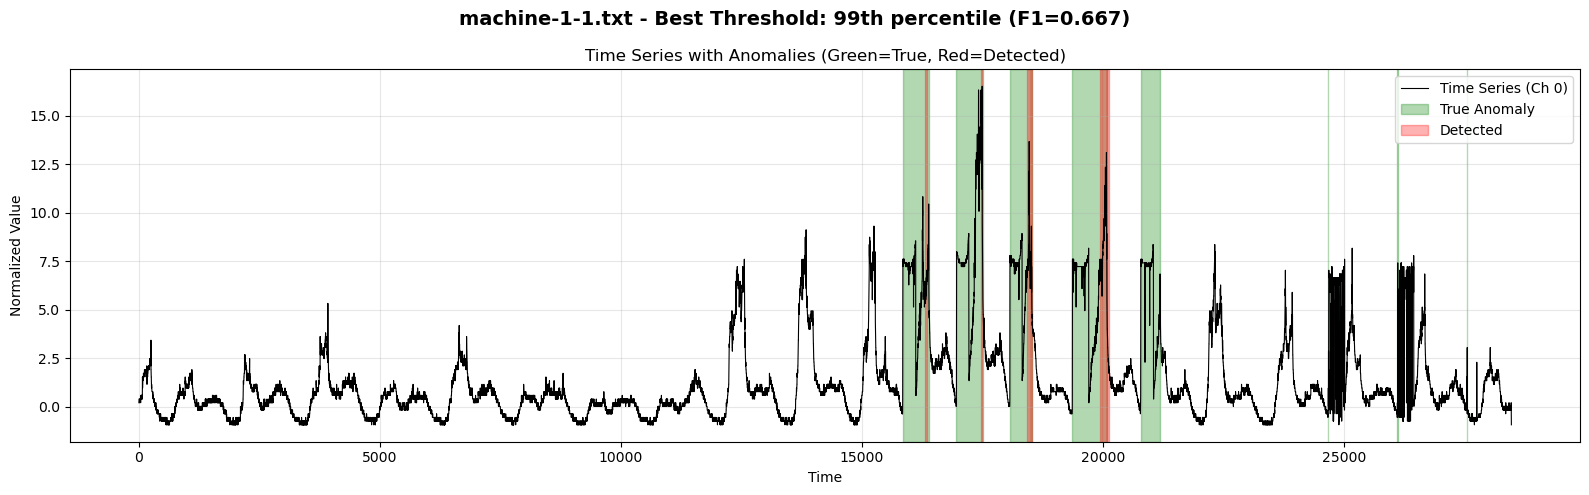


[2/5] Processing: machine-1-2.txt
Data shape: train=(23694, 38), test=(23694, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.2076
Epoch 2/20 | Loss: 3.0291
Epoch 3/20 | Loss: 2.8068
Epoch 4/20 | Loss: 2.5216
Epoch 5/20 | Loss: 2.1615
Epoch 6/20 | Loss: 1.7727
Epoch 7/20 | Loss: 1.4153
Epoch 8/20 | Loss: 1.2020
Epoch 9/20 | Loss: 1.0065
Epoch 10/20 | Loss: 0.8948
Epoch 11/20 | Loss: 0.8261
Epoch 12/20 | Loss: 0.7756
Epoch 13/20 | Loss: 0.7468
Epoch 14/20 | Loss: 0.7084
Epoch 15/20 | Loss: 0.6988
Epoch 16/20 | Loss: 0.6798
Epoch 17/2

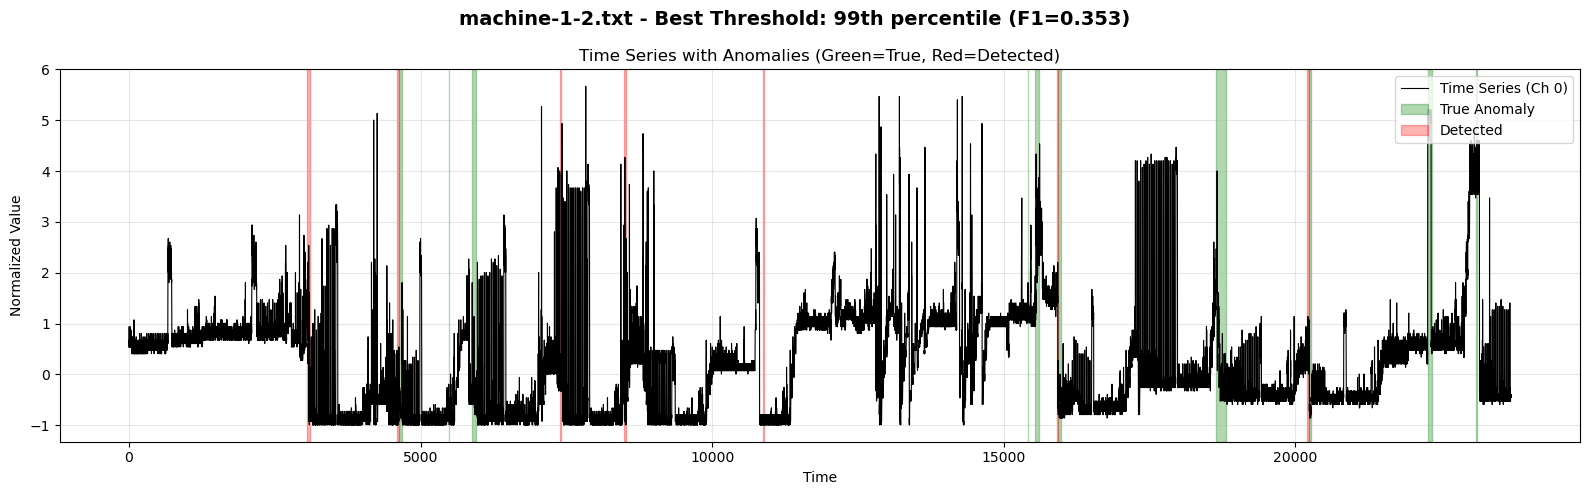


[3/5] Processing: machine-1-3.txt
Data shape: train=(23702, 38), test=(23703, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.1436
Epoch 2/20 | Loss: 2.9484
Epoch 3/20 | Loss: 2.7152
Epoch 4/20 | Loss: 2.4334
Epoch 5/20 | Loss: 2.1164
Epoch 6/20 | Loss: 1.7607
Epoch 7/20 | Loss: 1.4988
Epoch 8/20 | Loss: 1.2661
Epoch 9/20 | Loss: 1.0540
Epoch 10/20 | Loss: 0.9860
Epoch 11/20 | Loss: 0.8638
Epoch 12/20 | Loss: 0.7826
Epoch 13/20 | Loss: 0.7770
Epoch 14/20 | Loss: 0.7449
Epoch 15/20 | Loss: 0.7140
Epoch 16/20 | Loss: 0.7228
Epoch 17/2

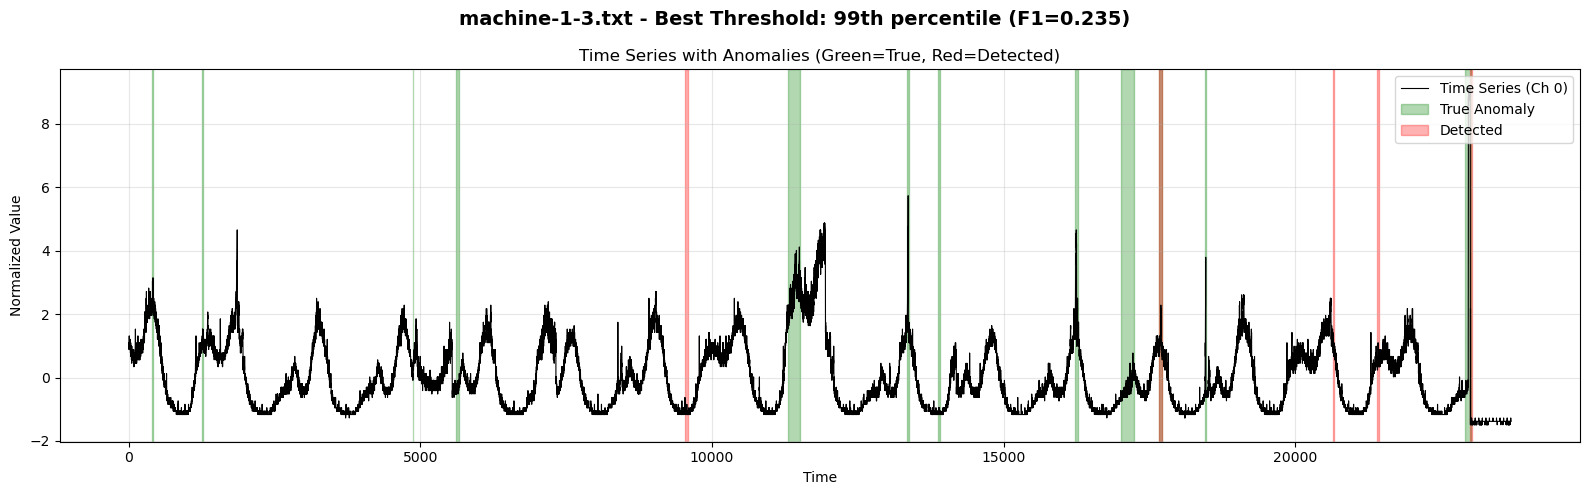


[4/5] Processing: machine-1-4.txt
Data shape: train=(23706, 38), test=(23707, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.1293
Epoch 2/20 | Loss: 2.8839
Epoch 3/20 | Loss: 2.5632
Epoch 4/20 | Loss: 2.2230
Epoch 5/20 | Loss: 1.8660
Epoch 6/20 | Loss: 1.4860
Epoch 7/20 | Loss: 1.1853
Epoch 8/20 | Loss: 1.0038
Epoch 9/20 | Loss: 0.8627
Epoch 10/20 | Loss: 0.7695
Epoch 11/20 | Loss: 0.6958
Epoch 12/20 | Loss: 0.6846
Epoch 13/20 | Loss: 0.6478
Epoch 14/20 | Loss: 0.6257
Epoch 15/20 | Loss: 0.5982
Epoch 16/20 | Loss: 0.6084
Epoch 17/2

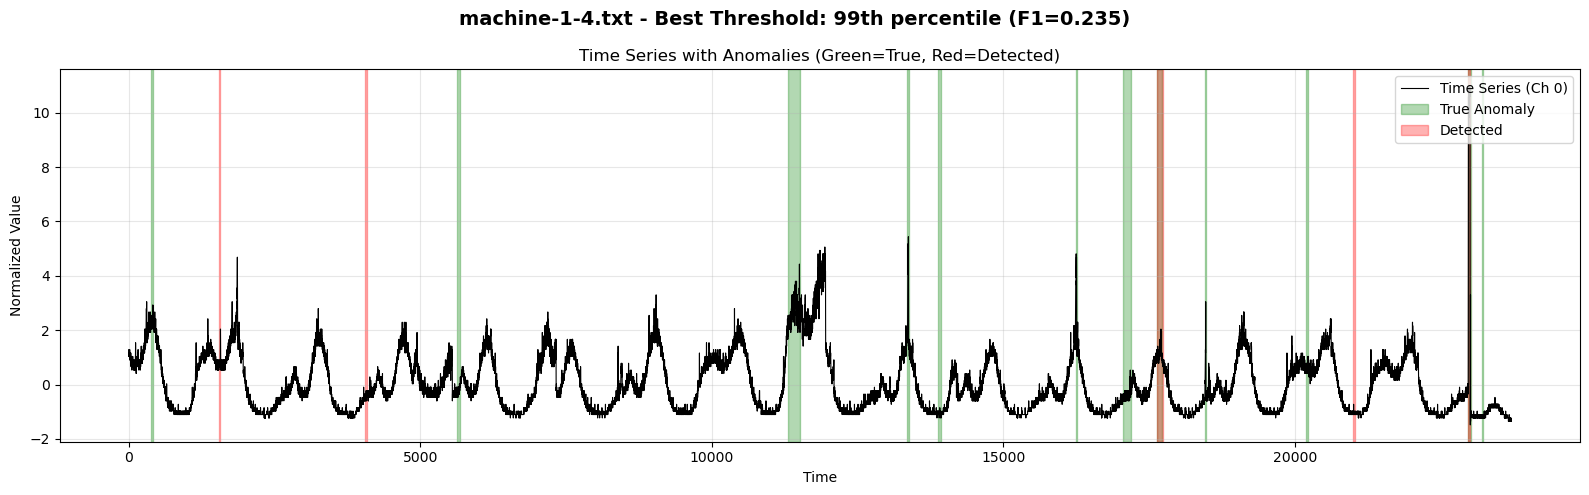


[5/5] Processing: machine-1-5.txt
Data shape: train=(23705, 38), test=(23706, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.0108
Epoch 2/20 | Loss: 2.7627
Epoch 3/20 | Loss: 2.4763
Epoch 4/20 | Loss: 2.1245
Epoch 5/20 | Loss: 1.7728
Epoch 6/20 | Loss: 1.5086
Epoch 7/20 | Loss: 1.2942
Epoch 8/20 | Loss: 1.1426
Epoch 9/20 | Loss: 1.0187
Epoch 10/20 | Loss: 0.9470
Epoch 11/20 | Loss: 0.8852
Epoch 12/20 | Loss: 0.8376
Epoch 13/20 | Loss: 0.7860
Epoch 14/20 | Loss: 0.7600
Epoch 15/20 | Loss: 0.7546
Epoch 16/20 | Loss: 0.7277
Epoch 17/2

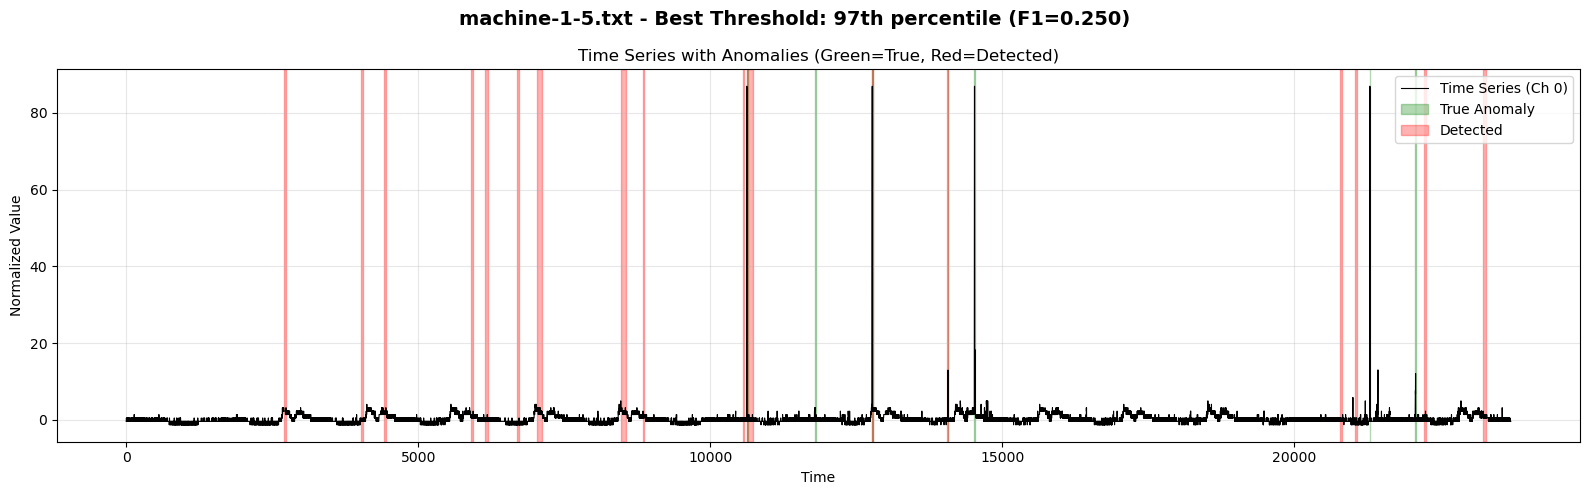

machine-1-1.txt                    1.0000     0.5000     0.6667         99th
machine-1-2.txt                    0.4286     0.3000     0.3529         99th
machine-1-3.txt                    0.4000     0.1667     0.2353         99th
machine-1-4.txt                    0.4000     0.1667     0.2353         99th
machine-1-5.txt                    0.1765     0.4286     0.2500         97th
────────────────────────────────────────────────────────────────────────────────
AVERAGE                            0.4810     0.3124     0.3480
────────────────────────────────────────────────────────────────────────────────

 Saved results to checkpoints_multiscale_adaptive_3/results.json

 Multi-Scale Anomaly Detection Complete!


In [6]:
"""
Training Script - Train models and save them
"""

if __name__ == "__main__":
    import os
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    # ==================== CONFIGURATION ====================
    # Multi-scale configuration
    MULTI_SCALE_WINDOWS = [32, 64, 128]  # Short, medium, long-term patterns
    # Reduced weight on short windows (32) to reduce false positives from noise
    SCALE_WEIGHTS = [0.1, 0.3, 0.6]      # Even more weight on long-term patterns to reduce FPs
    
    # Model configuration
    PRIMARY_WINDOW = 128
    D_MODEL = 64
    NUM_HEADS = 8
    NUM_LAYERS = 6
    NUM_PROTOTYPES = 32
    PATCH_SIZE = 16
    
    # Training configuration
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    VLM_FINETUNE_EPOCHS = 20
    VLM_LR = 1e-5
    TEMPERATURE = 0.1
    
    # Multi-threshold configuration (percentiles to evaluate)
    # Using higher thresholds to reduce false positives
    THRESHOLDS = [90,95, 97, 99]  # Higher thresholds = fewer false positives
    
    # Data configuration
    root = "ServerMachineDataset"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    label_dir = os.path.join(root, "test_label")
    save_dir = "checkpoints_multiscale_adaptive_3"
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Select files to process (first 5 for demo)
    smd_files = sorted([f for f in os.listdir(train_dir) if f.endswith(".txt")])
    smd_files = smd_files[:5]
    print(f"Processing {len(smd_files)} SMD files: {smd_files}\n")

    # ==================== TRAINING LOOP ====================
    results = []

    for file_idx, file_name in enumerate(smd_files):
        print("\n" + "="*80)
        print(f"[{file_idx + 1}/{len(smd_files)}] Processing: {file_name}")
        print("="*80)

        # Load data
        train_path = os.path.join(train_dir, file_name)
        test_path = os.path.join(test_dir, file_name)
        label_path = os.path.join(label_dir, file_name)

        if not os.path.exists(test_path):
            print(f"⚠ Test file missing, skipping...")
            continue

        train_series = np.loadtxt(train_path, delimiter=",")
        test_series = np.loadtxt(test_path, delimiter=",")
        labels = np.loadtxt(label_path, delimiter=",") if os.path.exists(label_path) else None

        # Ensure 2D
        if train_series.ndim == 1:
            train_series = train_series[:, None]
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        # Normalize
        mean = train_series.mean(axis=0)
        std = train_series.std(axis=0) + 1e-8
        train_series = (train_series - mean) / std
        test_series = (test_series - mean) / std

        num_channels = train_series.shape[1]
        print(f"Data shape: train={train_series.shape}, test={test_series.shape}, channels={num_channels}")

        # ==================== CREATE MULTI-SCALE MODEL ====================
        print(f"\n{'─'*80}")
        print("Creating Multi-Scale Model")
        print(f"{'─'*80}")
        
        model = AnomalyLLMViT(
            window_size=PRIMARY_WINDOW,
            num_channels=num_channels,
            stride=32,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            num_prototypes=NUM_PROTOTYPES,
            patch_size=PATCH_SIZE,
            multi_scale_windows=MULTI_SCALE_WINDOWS,
            scale_weights=SCALE_WEIGHTS
        ).to(device)

        # ==================== TRAIN MODEL ====================
        train_student_with_finetuned_teacher(
            model=model,
            train_series=train_series,
            device=device,
            has_labels=False,
            labels=None,
            num_epochs=NUM_EPOCHS,
            lr=LEARNING_RATE,
            lambda_kd=1.0,
            lambda_ce=0.1,
            lambda_var=0.01,
            finetune_vlm_first=True,
            vlm_finetune_epochs=VLM_FINETUNE_EPOCHS,
            vlm_lr=VLM_LR,
            num_prototypes=NUM_PROTOTYPES,
            temperature=TEMPERATURE
        )

        # Save model
        model_path = os.path.join(save_dir, file_name.replace(".txt", "_model.pth"))
        torch.save(model.state_dict(), model_path)
        print(f"✓ Saved model to {model_path}")

        # ==================== EVALUATION WITH MULTI-THRESHOLD ====================
        print(f"\n{'─'*80}")
        print("Evaluation with Multi-Threshold Selection")
        print(f"{'─'*80}")
        
        model.eval()
        
        if labels is None:
            print(" No labels available, skipping evaluation...")
            continue
        
        # Detect anomalies using multi-threshold approach (picks best F1)
        # Added min_anomaly_duration and merge_gap to reduce false positives
        anomalies, result_info = model.detect_anomalies(
            test_series,
            device,
            labels=labels,
            thresholds=THRESHOLDS,
            min_anomaly_duration=15,  # Filter anomalies shorter than 8 timesteps
            merge_gap=15             # Merge anomalies within 15 timesteps of each other
        )
        
        # Extract results
        scores = result_info['scores']
        best_threshold = result_info['best_threshold']
        best_f1 = result_info['best_f1']
        best_preds = result_info['best_preds']
        all_metrics = result_info['all_metrics']
        
        print(f"\n Best Results (at {best_threshold}th percentile):")
        print(f"  Precision: {result_info['best_precision']:.4f}")
        print(f"  Recall:    {result_info['best_recall']:.4f}")
        print(f"  F1-Score:  {best_f1:.4f}")
        
        results.append({
            'file': file_name,
            'precision': result_info['best_precision'],
            'recall': result_info['best_recall'],
            'f1': best_f1,
            'num_anomalies': len(anomalies),
            'best_threshold': best_threshold,
            'all_metrics': all_metrics
        })

        # ==================== VISUALIZATION ====================
        print(f"\n{'─'*80}")
        print("Generating Visualization")
        print(f"{'─'*80}")
        
        fig, ax = plt.subplots(figsize=(16, 5))
        fig.suptitle(f'{file_name} - Best Threshold: {best_threshold}th percentile (F1={best_f1:.3f})', 
                     fontsize=14, fontweight='bold')
        
        # Time series with detected vs true anomalies
        ax.plot(test_series[:, 0], color='black', linewidth=0.8, label='Time Series (Ch 0)')
        
        # Highlight true anomalies (green)
        true_intervals = get_intervals_from_labels(labels.astype(int))
        for idx, (start, end) in enumerate(true_intervals):
            ax.axvspan(start, end, color='green', alpha=0.3, 
                       label='True Anomaly' if idx == 0 else '')
        
        # Highlight detected anomalies (red)
        pred_intervals = get_intervals_from_labels(best_preds)
        for idx, (start, end) in enumerate(pred_intervals):
            ax.axvspan(start, end, color='red', alpha=0.3, 
                       label='Detected' if idx == 0 else '')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Normalized Value')
        ax.set_title('Time Series with Anomalies (Green=True, Red=Detected)')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        fig_path = os.path.join(save_dir, file_name.replace(".txt", "_visualization.png"))
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved visualization to {fig_path}")
        plt.show()
        
        # Cleanup
        del model
        torch.cuda.empty_cache()

    # ==================== SUMMARY ====================
    if results:
        total_p, total_r, total_f1 = 0, 0, 0
        for res in results:
            print(f"{res['file']:<30} {res['precision']:>10.4f} {res['recall']:>10.4f} "
                  f"{res['f1']:>10.4f} {res['best_threshold']:>10}th")
            total_p += res['precision']
            total_r += res['recall']
            total_f1 += res['f1']
        
        print(f"{'─'*80}")
        print(f"{'AVERAGE':<30} {total_p/len(results):>10.4f} {total_r/len(results):>10.4f} "
              f"{total_f1/len(results):>10.4f}")
        print(f"{'─'*80}")
        
        # Save results
        results_path = os.path.join(save_dir, "results.json")
        import json
        with open(results_path, 'w') as f:
            json.dump({
                'config': {
                    'multi_scale_windows': MULTI_SCALE_WINDOWS,
                    'scale_weights': SCALE_WEIGHTS,
                    'thresholds': THRESHOLDS,
                    'num_epochs': NUM_EPOCHS,
                    'num_prototypes': NUM_PROTOTYPES
                },
                'results': [{k: v for k, v in r.items() if k != 'all_metrics'} for r in results]
            }, f, indent=4)
        print(f"\n Saved results to {results_path}")

print("\n Multi-Scale Anomaly Detection Complete!")

Using device: cuda

Processing 5 SMD files: ['machine-1-6.txt', 'machine-1-7.txt', 'machine-1-8.txt', 'machine-2-1.txt', 'machine-2-2.txt']


[1/5] Processing: machine-1-6.txt
Data shape: train=(23688, 38), test=(23689, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.0957
Epoch 2/20 | Loss: 2.9380
Epoch 3/20 | Loss: 2.6334
Epoch 4/20 | Loss: 2.3035
Epoch 5/20 | Loss: 1.8804
Epoch 6/20 | Loss: 1.4772
Epoch 7/20 | Loss: 1.1480
Epoch 8/20 | Loss: 0.9572
Epoch 9/20 | Loss: 0.8178
Epoch 10/20 | Loss: 0.7253
Epoch 11/20 | Loss: 0.7114
Epoc

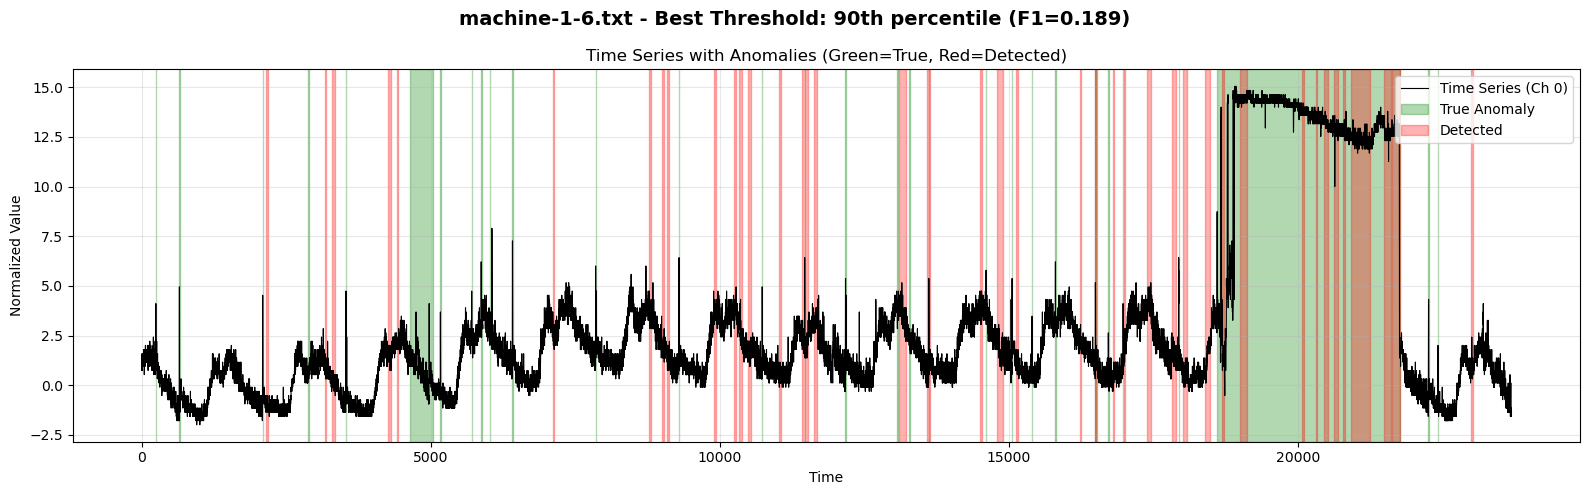


[2/5] Processing: machine-1-7.txt
Data shape: train=(23697, 38), test=(23697, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1133)')))"), '(Request ID: b67227c4-7287-41fb-9653-a01dc16fa80d)')' thrown while requesting HEAD https://huggingface.co/timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].


[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 2.8560
Epoch 2/20 | Loss: 2.5596
Epoch 3/20 | Loss: 2.2150
Epoch 4/20 | Loss: 1.8857
Epoch 5/20 | Loss: 1.5879
Epoch 6/20 | Loss: 1.3424
Epoch 7/20 | Loss: 1.1542
Epoch 8/20 | Loss: 1.0085
Epoch 9/20 | Loss: 0.8887
Epoch 10/20 | Loss: 0.8377
Epoch 11/20 | Loss: 0.7608
Epoch 12/20 | Loss: 0.7454
Epoch 13/20 | Loss: 0.6818
Epoch 14/20 | Loss: 0.6871
Epoch 15/20 | Loss: 0.6741
Epoch 16/20 | Loss: 0.6701
Epoch 17/20 | Loss: 0.6648
Epoch 18/20 | Loss: 0.6486
Epoch 19/20 | Loss: 0.6551
Epoch 20/20 | Loss: 0.6734

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Computing Teacher Prototypes via K-means Clustering
Clustering 737 teacher embeddings into 32 prototypes...
Teacher prototypes shape: torch.Size([32, 64])


Training Student with Prototype-

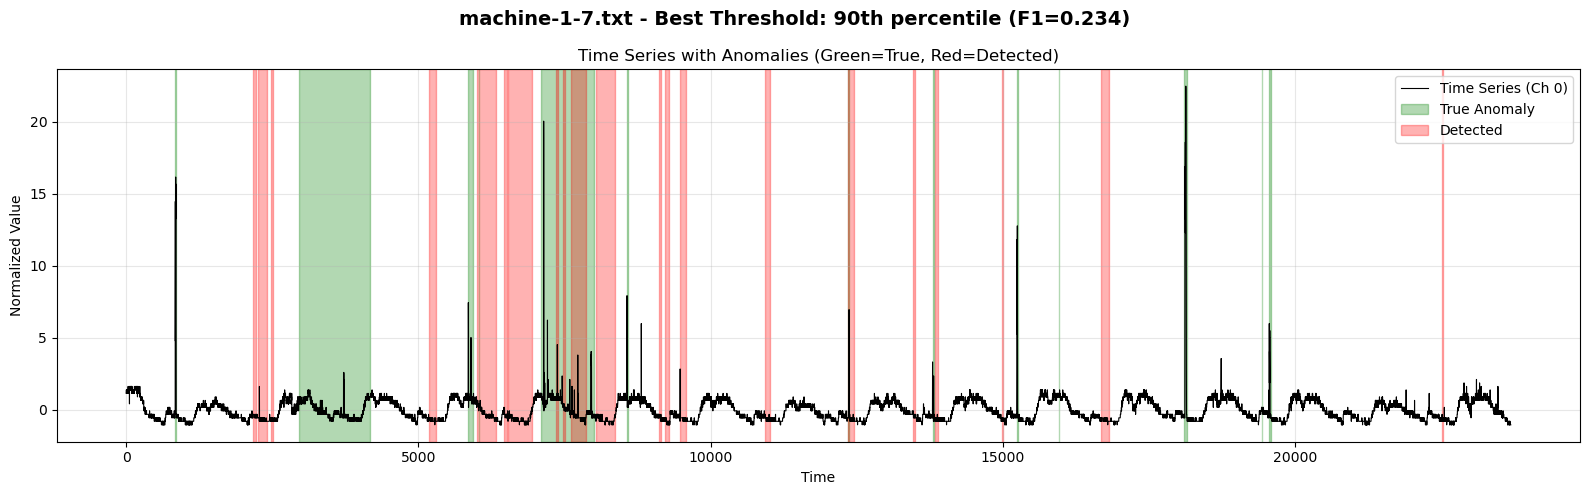


[3/5] Processing: machine-1-8.txt
Data shape: train=(23698, 38), test=(23699, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.2834
Epoch 2/20 | Loss: 3.1699
Epoch 3/20 | Loss: 3.0684
Epoch 4/20 | Loss: 2.8754
Epoch 5/20 | Loss: 2.6121
Epoch 6/20 | Loss: 2.2620
Epoch 7/20 | Loss: 1.8799
Epoch 8/20 | Loss: 1.5273
Epoch 9/20 | Loss: 1.2603
Epoch 10/20 | Loss: 1.0500
Epoch 11/20 | Loss: 0.9417
Epoch 12/20 | Loss: 0.8579
Epoch 13/20 | Loss: 0.8026
Epoch 14/20 | Loss: 0.7712
Epoch 15/20 | Loss: 0.7514
Epoch 16/20 | Loss: 0.7430
Epoch 17/2

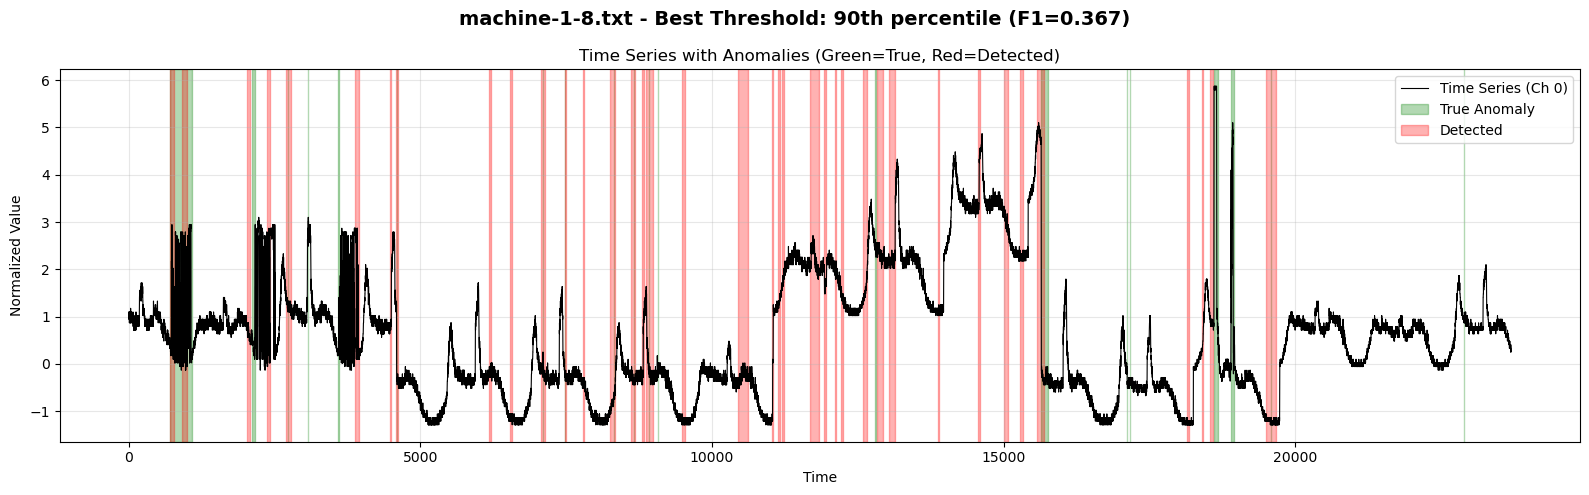


[4/5] Processing: machine-2-1.txt
Data shape: train=(23693, 38), test=(23694, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]
[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.0986
Epoch 2/20 | Loss: 2.9217
Epoch 3/20 | Loss: 2.6233
Epoch 4/20 | Loss: 2.2356
Epoch 5/20 | Loss: 1.8202
Epoch 6/20 | Loss: 1.4665
Epoch 7/20 | Loss: 1.2424
Epoch 8/20 | Loss: 1.0918
Epoch 9/20 | Loss: 1.0053
Epoch 10/20 | Loss: 0.9442
Epoch 11/20 | Loss: 0.8778
Epoch 12/20 | Loss: 0.8339


In [ ]:
#for files 5 to 10
"""
Training Script - Train models and save them
"""

if __name__ == "__main__":
    import os
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    # ==================== CONFIGURATION ====================
    # Multi-scale configuration
    MULTI_SCALE_WINDOWS = [32, 64, 128]  # Short, medium, long-term patterns
    # Reduced weight on short windows (32) to reduce false positives from noise
    SCALE_WEIGHTS = [0.1, 0.3, 0.6]      # Even more weight on long-term patterns to reduce FPs
    
    # Model configuration
    PRIMARY_WINDOW = 128
    D_MODEL = 64
    NUM_HEADS = 8
    NUM_LAYERS = 6
    NUM_PROTOTYPES = 32
    PATCH_SIZE = 16
    
    # Training configuration
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    VLM_FINETUNE_EPOCHS = 20
    VLM_LR = 1e-5
    TEMPERATURE = 0.1
    
    # Multi-threshold configuration (percentiles to evaluate)
    # Using higher thresholds to reduce false positives
    THRESHOLDS = [90,95, 97, 99]  # Higher thresholds = fewer false positives
    
    # Data configuration
    root = "ServerMachineDataset"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    label_dir = os.path.join(root, "test_label")
    save_dir = "checkpoints_multiscale_adaptive_3"
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Select files to process (first 5 for demo)
    smd_files = sorted([f for f in os.listdir(train_dir) if f.endswith(".txt")])
    smd_files = smd_files[5:10]
    print(f"Processing {len(smd_files)} SMD files: {smd_files}\n")

    # ==================== TRAINING LOOP ====================
    results = []

    for file_idx, file_name in enumerate(smd_files):
        print("\n" + "="*80)
        print(f"[{file_idx + 1}/{len(smd_files)}] Processing: {file_name}")
        print("="*80)

        # Load data
        train_path = os.path.join(train_dir, file_name)
        test_path = os.path.join(test_dir, file_name)
        label_path = os.path.join(label_dir, file_name)

        if not os.path.exists(test_path):
            print(f"⚠ Test file missing, skipping...")
            continue

        train_series = np.loadtxt(train_path, delimiter=",")
        test_series = np.loadtxt(test_path, delimiter=",")
        labels = np.loadtxt(label_path, delimiter=",") if os.path.exists(label_path) else None

        # Ensure 2D
        if train_series.ndim == 1:
            train_series = train_series[:, None]
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        # Normalize
        mean = train_series.mean(axis=0)
        std = train_series.std(axis=0) + 1e-8
        train_series = (train_series - mean) / std
        test_series = (test_series - mean) / std

        num_channels = train_series.shape[1]
        print(f"Data shape: train={train_series.shape}, test={test_series.shape}, channels={num_channels}")

        # ==================== CREATE MULTI-SCALE MODEL ====================
        print(f"\n{'─'*80}")
        print("Creating Multi-Scale Model")
        print(f"{'─'*80}")
        
        model = AnomalyLLMViT(
            window_size=PRIMARY_WINDOW,
            num_channels=num_channels,
            stride=32,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            num_prototypes=NUM_PROTOTYPES,
            patch_size=PATCH_SIZE,
            multi_scale_windows=MULTI_SCALE_WINDOWS,
            scale_weights=SCALE_WEIGHTS
        ).to(device)

        # ==================== TRAIN MODEL ====================
        train_student_with_finetuned_teacher(
            model=model,
            train_series=train_series,
            device=device,
            has_labels=False,
            labels=None,
            num_epochs=NUM_EPOCHS,
            lr=LEARNING_RATE,
            lambda_kd=1.0,
            lambda_ce=0.1,
            lambda_var=0.01,
            finetune_vlm_first=True,
            vlm_finetune_epochs=VLM_FINETUNE_EPOCHS,
            vlm_lr=VLM_LR,
            num_prototypes=NUM_PROTOTYPES,
            temperature=TEMPERATURE
        )

        # Save model
        model_path = os.path.join(save_dir, file_name.replace(".txt", "_model.pth"))
        torch.save(model.state_dict(), model_path)
        print(f"✓ Saved model to {model_path}")

        # ==================== EVALUATION WITH MULTI-THRESHOLD ====================
        print(f"\n{'─'*80}")
        print("Evaluation with Multi-Threshold Selection")
        print(f"{'─'*80}")
        
        model.eval()
        
        if labels is None:
            print(" No labels available, skipping evaluation...")
            continue
        
        # Detect anomalies using multi-threshold approach (picks best F1)
        # Added min_anomaly_duration and merge_gap to reduce false positives
        anomalies, result_info = model.detect_anomalies(
            test_series,
            device,
            labels=labels,
            thresholds=THRESHOLDS,
            min_anomaly_duration=15,  # Filter anomalies shorter than 8 timesteps
            merge_gap=15             # Merge anomalies within 15 timesteps of each other
        )
        
        # Extract results
        scores = result_info['scores']
        best_threshold = result_info['best_threshold']
        best_f1 = result_info['best_f1']
        best_preds = result_info['best_preds']
        all_metrics = result_info['all_metrics']
        
        print(f"\n Best Results (at {best_threshold}th percentile):")
        print(f"  Precision: {result_info['best_precision']:.4f}")
        print(f"  Recall:    {result_info['best_recall']:.4f}")
        print(f"  F1-Score:  {best_f1:.4f}")
        
        results.append({
            'file': file_name,
            'precision': result_info['best_precision'],
            'recall': result_info['best_recall'],
            'f1': best_f1,
            'num_anomalies': len(anomalies),
            'best_threshold': best_threshold,
            'all_metrics': all_metrics
        })

        # ==================== VISUALIZATION ====================
        print(f"\n{'─'*80}")
        print("Generating Visualization")
        print(f"{'─'*80}")
        
        fig, ax = plt.subplots(figsize=(16, 5))
        fig.suptitle(f'{file_name} - Best Threshold: {best_threshold}th percentile (F1={best_f1:.3f})', 
                     fontsize=14, fontweight='bold')
        
        # Time series with detected vs true anomalies
        ax.plot(test_series[:, 0], color='black', linewidth=0.8, label='Time Series (Ch 0)')
        
        # Highlight true anomalies (green)
        true_intervals = get_intervals_from_labels(labels.astype(int))
        for idx, (start, end) in enumerate(true_intervals):
            ax.axvspan(start, end, color='green', alpha=0.3, 
                       label='True Anomaly' if idx == 0 else '')
        
        # Highlight detected anomalies (red)
        pred_intervals = get_intervals_from_labels(best_preds)
        for idx, (start, end) in enumerate(pred_intervals):
            ax.axvspan(start, end, color='red', alpha=0.3, 
                       label='Detected' if idx == 0 else '')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Normalized Value')
        ax.set_title('Time Series with Anomalies (Green=True, Red=Detected)')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        fig_path = os.path.join(save_dir, file_name.replace(".txt", "_visualization.png"))
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved visualization to {fig_path}")
        plt.show()
        
        # Cleanup
        del model
        torch.cuda.empty_cache()

    # ==================== SUMMARY ====================
    if results:
        total_p, total_r, total_f1 = 0, 0, 0
        for res in results:
            print(f"{res['file']:<30} {res['precision']:>10.4f} {res['recall']:>10.4f} "
                  f"{res['f1']:>10.4f} {res['best_threshold']:>10}th")
            total_p += res['precision']
            total_r += res['recall']
            total_f1 += res['f1']
        
        print(f"{'─'*80}")
        print(f"{'AVERAGE':<30} {total_p/len(results):>10.4f} {total_r/len(results):>10.4f} "
              f"{total_f1/len(results):>10.4f}")
        print(f"{'─'*80}")
        
        # Save results
        results_path = os.path.join(save_dir, "results.json")
        import json
        with open(results_path, 'w') as f:
            json.dump({
                'config': {
                    'multi_scale_windows': MULTI_SCALE_WINDOWS,
                    'scale_weights': SCALE_WEIGHTS,
                    'thresholds': THRESHOLDS,
                    'num_epochs': NUM_EPOCHS,
                    'num_prototypes': NUM_PROTOTYPES
                },
                'results': [{k: v for k, v in r.items() if k != 'all_metrics'} for r in results]
            }, f, indent=4)
        print(f"\n Saved results to {results_path}")

print("\n Multi-Scale Anomaly Detection Complete!")

Using device: cuda

Processing 5 SMD files: ['machine-2-1.txt', 'machine-2-2.txt', 'machine-2-3.txt', 'machine-2-4.txt', 'machine-2-5.txt']


[1/5] Processing: machine-2-1.txt
Data shape: train=(23693, 38), test=(23694, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2a6c9ed30>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 9f3ddea0-beff-48d2-956a-8715dbbacb44)')' thrown while requesting HEAD https://huggingface.co/timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2a6c85fa0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: fe107e29-6ea7-4a3d-a1d2-ab58cea42170)')' 

[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.1797
Epoch 2/20 | Loss: 2.8744
Epoch 3/20 | Loss: 2.4141
Epoch 4/20 | Loss: 1.9223
Epoch 5/20 | Loss: 1.4956
Epoch 6/20 | Loss: 1.1900
Epoch 7/20 | Loss: 1.0206
Epoch 8/20 | Loss: 0.9289
Epoch 9/20 | Loss: 0.8497
Epoch 10/20 | Loss: 0.7982
Epoch 11/20 | Loss: 0.7678
Epoch 12/20 | Loss: 0.7338
Epoch 13/20 | Loss: 0.7222
Epoch 14/20 | Loss: 0.6928
Epoch 15/20 | Loss: 0.6631
Epoch 16/20 | Loss: 0.6664
Epoch 17/20 | Loss: 0.6639
Epoch 18/20 | Loss: 0.6516
Epoch 19/20 | Loss: 0.6501
Epoch 20/20 | Loss: 0.6292

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Computing Teacher Prototypes via K-means Clustering
Clustering 737 teacher embeddings into 32 prototypes...
Teacher prototypes shape: torch.Size([32, 64])


Training Student with Prototype-

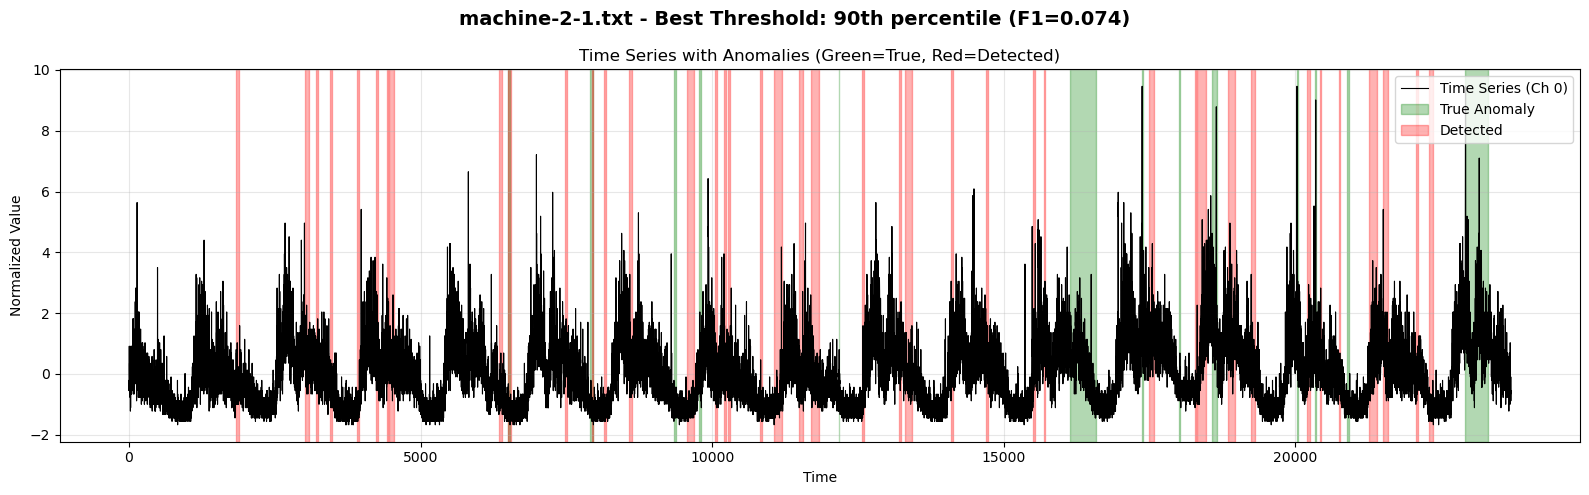


[2/5] Processing: machine-2-2.txt
Data shape: train=(23699, 38), test=(23700, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2687274c0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 902df61a-379c-49d6-83d8-568110502247)')' thrown while requesting HEAD https://huggingface.co/timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe268727190>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 5d2cd5fe-5351-4d62-91c2-6f9e9fa7b9d5)')' 

[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 2.8268
Epoch 2/20 | Loss: 2.3160
Epoch 3/20 | Loss: 1.8293
Epoch 4/20 | Loss: 1.4674
Epoch 5/20 | Loss: 1.1999
Epoch 6/20 | Loss: 1.0720
Epoch 7/20 | Loss: 0.9337
Epoch 8/20 | Loss: 0.8448
Epoch 9/20 | Loss: 0.7744
Epoch 10/20 | Loss: 0.7332
Epoch 11/20 | Loss: 0.6687
Epoch 12/20 | Loss: 0.6390
Epoch 13/20 | Loss: 0.6148
Epoch 14/20 | Loss: 0.6218
Epoch 15/20 | Loss: 0.6090
Epoch 16/20 | Loss: 0.5919
Epoch 17/20 | Loss: 0.5960
Epoch 18/20 | Loss: 0.5886
Epoch 19/20 | Loss: 0.5974
Epoch 20/20 | Loss: 0.5723

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Computing Teacher Prototypes via K-means Clustering
Clustering 737 teacher embeddings into 32 prototypes...
Teacher prototypes shape: torch.Size([32, 64])


Training Student with Prototype-

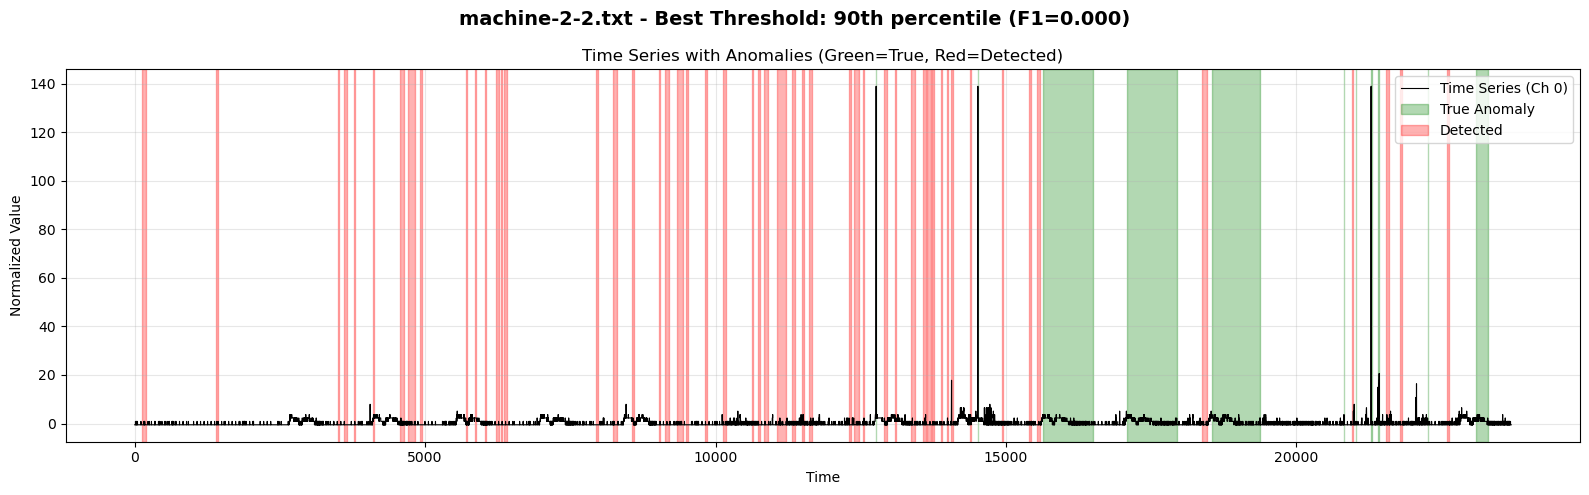


[3/5] Processing: machine-2-3.txt
Data shape: train=(23688, 38), test=(23689, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2a6c6bb50>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 3cf6f4c6-35e6-44c2-904f-f75eacbf501d)')' thrown while requesting HEAD https://huggingface.co/timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2a6ca76a0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 716e959d-d039-424a-8fa8-1df95311e18d)')' 

[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 2.9987
Epoch 2/20 | Loss: 2.7890
Epoch 3/20 | Loss: 2.5802
Epoch 4/20 | Loss: 2.3257
Epoch 5/20 | Loss: 2.0169
Epoch 6/20 | Loss: 1.7154
Epoch 7/20 | Loss: 1.4847
Epoch 8/20 | Loss: 1.2865
Epoch 9/20 | Loss: 1.1312
Epoch 10/20 | Loss: 1.0320
Epoch 11/20 | Loss: 0.9355
Epoch 12/20 | Loss: 0.8902
Epoch 13/20 | Loss: 0.8179
Epoch 14/20 | Loss: 0.7777
Epoch 15/20 | Loss: 0.7639
Epoch 16/20 | Loss: 0.7562
Epoch 17/20 | Loss: 0.7315
Epoch 18/20 | Loss: 0.7403
Epoch 19/20 | Loss: 0.7395
Epoch 20/20 | Loss: 0.7153

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Computing Teacher Prototypes via K-means Clustering
Clustering 737 teacher embeddings into 32 prototypes...
Teacher prototypes shape: torch.Size([32, 64])


Training Student with Prototype-

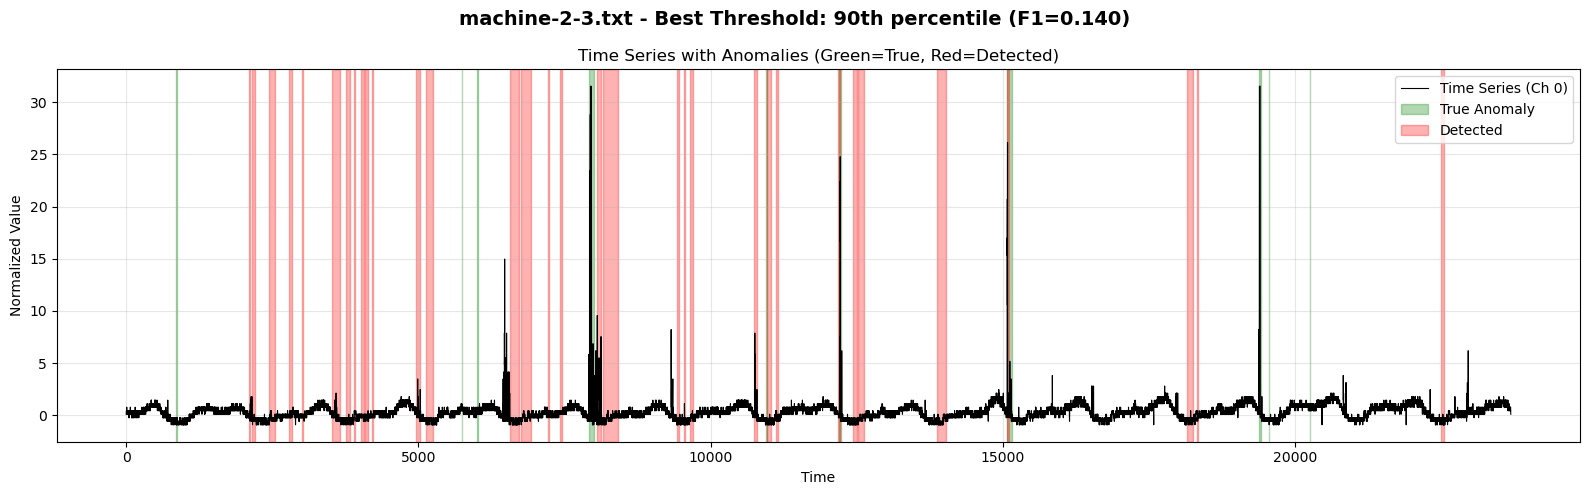


[4/5] Processing: machine-2-4.txt
Data shape: train=(23689, 38), test=(23689, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2a6ca4c70>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: f13feb7d-541d-44e6-ad35-2863ec4c4521)')' thrown while requesting HEAD https://huggingface.co/timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe2a6c53df0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 9d747e58-0d2d-4153-ab95-d9cb8b0ecee7)')' 

[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 3.0152
Epoch 2/20 | Loss: 2.7392
Epoch 3/20 | Loss: 2.3644
Epoch 4/20 | Loss: 1.9076
Epoch 5/20 | Loss: 1.4727
Epoch 6/20 | Loss: 1.1671
Epoch 7/20 | Loss: 0.9628
Epoch 8/20 | Loss: 0.7990
Epoch 9/20 | Loss: 0.6822
Epoch 10/20 | Loss: 0.6114
Epoch 11/20 | Loss: 0.5788
Epoch 12/20 | Loss: 0.5513
Epoch 13/20 | Loss: 0.5237
Epoch 14/20 | Loss: 0.5342
Epoch 15/20 | Loss: 0.5239
Epoch 16/20 | Loss: 0.4844
Epoch 17/20 | Loss: 0.4872
Epoch 18/20 | Loss: 0.4941
Epoch 19/20 | Loss: 0.4862
Epoch 20/20 | Loss: 0.4794

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Computing Teacher Prototypes via K-means Clustering
Clustering 737 teacher embeddings into 32 prototypes...
Teacher prototypes shape: torch.Size([32, 64])


Training Student with Prototype-

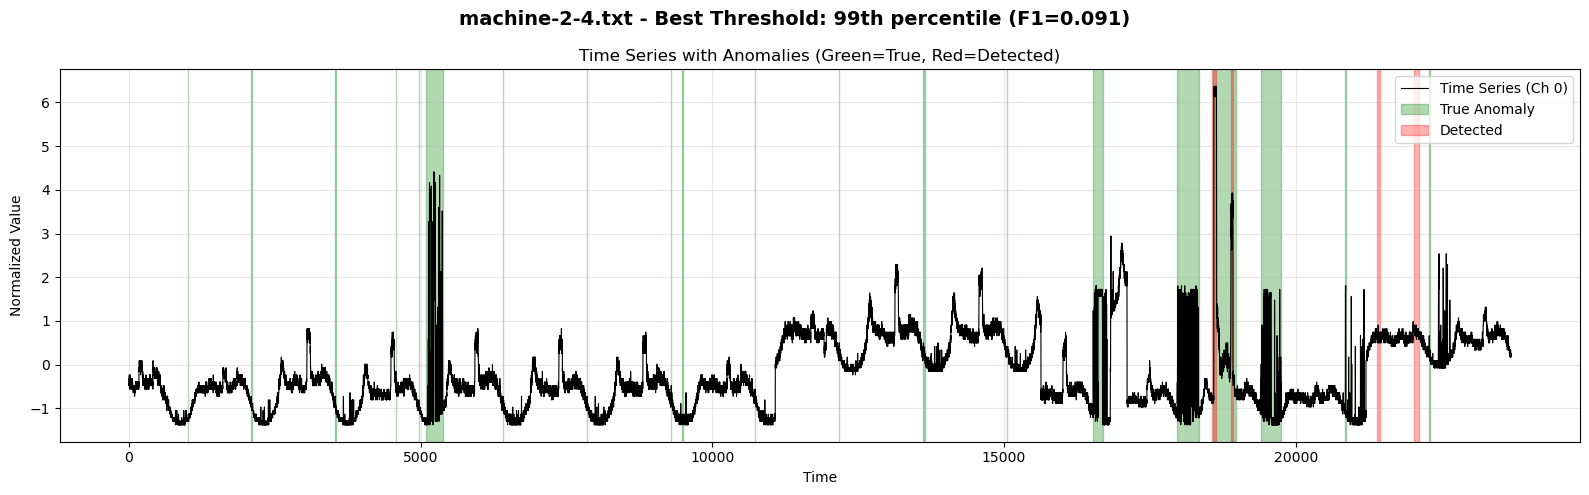


[5/5] Processing: machine-2-5.txt
Data shape: train=(23688, 38), test=(23689, 38), channels=38

────────────────────────────────────────────────────────────────────────────────
Creating Multi-Scale Model
────────────────────────────────────────────────────────────────────────────────
Multi-scale windows: [32, 64, 128]
Scale weights: [0.1, 0.3, 0.6]


'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe27ad6fa60>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: b7dc403e-e1c8-4984-9c01-1f4a1d7bc96e)')' thrown while requesting HEAD https://huggingface.co/timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_clip_224.laion400m_e32/resolve/main/open_clip_model.safetensors (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe27ad6feb0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 3ef34ffc-aba5-400e-84a4-48b91bd4eec1)')' 

[Info] Detected teacher output dimension: 768

Fine-tuning Pre-trained VLM Teacher (with Adapter)
Epochs: 20
Learning Rate: 1e-05
Freeze encoder: True
Fine-tuning last 2 layers only

Number of training windows: 737
Epoch 1/20 | Loss: 2.7978
Epoch 2/20 | Loss: 2.5159
Epoch 3/20 | Loss: 2.1450
Epoch 4/20 | Loss: 1.7433
Epoch 5/20 | Loss: 1.3489
Epoch 6/20 | Loss: 1.0849
Epoch 7/20 | Loss: 0.8779
Epoch 8/20 | Loss: 0.7773
Epoch 9/20 | Loss: 0.6558
Epoch 10/20 | Loss: 0.5970
Epoch 11/20 | Loss: 0.5554
Epoch 12/20 | Loss: 0.5365
Epoch 13/20 | Loss: 0.4968
Epoch 14/20 | Loss: 0.4958
Epoch 15/20 | Loss: 0.4707
Epoch 16/20 | Loss: 0.4607
Epoch 17/20 | Loss: 0.4404
Epoch 18/20 | Loss: 0.4531
Epoch 19/20 | Loss: 0.4348
Epoch 20/20 | Loss: 0.4450

VLM Teacher Fine-tuning Complete — Adapter Updated and Frozen


Computing Teacher Prototypes via K-means Clustering
Clustering 737 teacher embeddings into 32 prototypes...
Teacher prototypes shape: torch.Size([32, 64])


Training Student with Prototype-

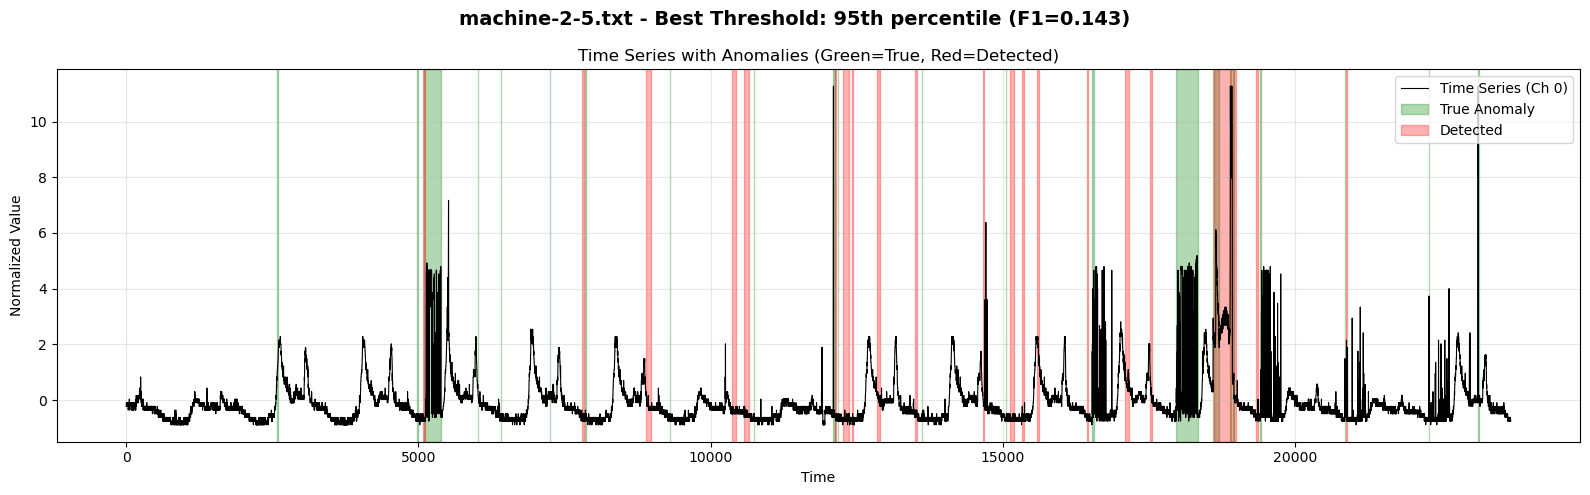

machine-2-1.txt                    0.0488     0.1538     0.0741         90th
machine-2-2.txt                    0.0000     0.0000     0.0000         90th
machine-2-3.txt                    0.0909     0.3000     0.1395         90th
machine-2-4.txt                    0.5000     0.0500     0.0909         99th
machine-2-5.txt                    0.1429     0.1429     0.1429         95th
────────────────────────────────────────────────────────────────────────────────
AVERAGE                            0.1565     0.1293     0.0895
────────────────────────────────────────────────────────────────────────────────

 Saved results to checkpoints_multiscale_adaptive_3/results.json

 Multi-Scale Anomaly Detection Complete!


In [6]:
#for files 8 to 13
"""
Training Script - Train models and save them
"""

if __name__ == "__main__":
    import os
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    # ==================== CONFIGURATION ====================
    # Multi-scale configuration
    MULTI_SCALE_WINDOWS = [32, 64, 128]  # Short, medium, long-term patterns
    # Reduced weight on short windows (32) to reduce false positives from noise
    SCALE_WEIGHTS = [0.1, 0.3, 0.6]      # Even more weight on long-term patterns to reduce FPs
    
    # Model configuration
    PRIMARY_WINDOW = 128
    D_MODEL = 64
    NUM_HEADS = 8
    NUM_LAYERS = 6
    NUM_PROTOTYPES = 32
    PATCH_SIZE = 16
    
    # Training configuration
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    VLM_FINETUNE_EPOCHS = 20
    VLM_LR = 1e-5
    TEMPERATURE = 0.1
    
    # Multi-threshold configuration (percentiles to evaluate)
    # Using higher thresholds to reduce false positives
    THRESHOLDS = [90,95, 97, 99]  # Higher thresholds = fewer false positives
    
    # Data configuration
    root = "ServerMachineDataset"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    label_dir = os.path.join(root, "test_label")
    save_dir = "checkpoints_multiscale_adaptive_3"
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Select files to process (first 5 for demo)
    smd_files = sorted([f for f in os.listdir(train_dir) if f.endswith(".txt")])
    smd_files = smd_files[8:13]
    print(f"Processing {len(smd_files)} SMD files: {smd_files}\n")

    # ==================== TRAINING LOOP ====================
    results = []

    for file_idx, file_name in enumerate(smd_files):
        print("\n" + "="*80)
        print(f"[{file_idx + 1}/{len(smd_files)}] Processing: {file_name}")
        print("="*80)

        # Load data
        train_path = os.path.join(train_dir, file_name)
        test_path = os.path.join(test_dir, file_name)
        label_path = os.path.join(label_dir, file_name)

        if not os.path.exists(test_path):
            print(f"⚠ Test file missing, skipping...")
            continue

        train_series = np.loadtxt(train_path, delimiter=",")
        test_series = np.loadtxt(test_path, delimiter=",")
        labels = np.loadtxt(label_path, delimiter=",") if os.path.exists(label_path) else None

        # Ensure 2D
        if train_series.ndim == 1:
            train_series = train_series[:, None]
        if test_series.ndim == 1:
            test_series = test_series[:, None]

        # Normalize
        mean = train_series.mean(axis=0)
        std = train_series.std(axis=0) + 1e-8
        train_series = (train_series - mean) / std
        test_series = (test_series - mean) / std

        num_channels = train_series.shape[1]
        print(f"Data shape: train={train_series.shape}, test={test_series.shape}, channels={num_channels}")

        # ==================== CREATE MULTI-SCALE MODEL ====================
        print(f"\n{'─'*80}")
        print("Creating Multi-Scale Model")
        print(f"{'─'*80}")
        
        model = AnomalyLLMViT(
            window_size=PRIMARY_WINDOW,
            num_channels=num_channels,
            stride=32,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            num_prototypes=NUM_PROTOTYPES,
            patch_size=PATCH_SIZE,
            multi_scale_windows=MULTI_SCALE_WINDOWS,
            scale_weights=SCALE_WEIGHTS
        ).to(device)

        # ==================== TRAIN MODEL ====================
        train_student_with_finetuned_teacher(
            model=model,
            train_series=train_series,
            device=device,
            has_labels=False,
            labels=None,
            num_epochs=NUM_EPOCHS,
            lr=LEARNING_RATE,
            lambda_kd=1.0,
            lambda_ce=0.1,
            lambda_var=0.01,
            finetune_vlm_first=True,
            vlm_finetune_epochs=VLM_FINETUNE_EPOCHS,
            vlm_lr=VLM_LR,
            num_prototypes=NUM_PROTOTYPES,
            temperature=TEMPERATURE
        )

        # Save model
        model_path = os.path.join(save_dir, file_name.replace(".txt", "_model.pth"))
        torch.save(model.state_dict(), model_path)
        print(f"✓ Saved model to {model_path}")

        # ==================== EVALUATION WITH MULTI-THRESHOLD ====================
        print(f"\n{'─'*80}")
        print("Evaluation with Multi-Threshold Selection")
        print(f"{'─'*80}")
        
        model.eval()
        
        if labels is None:
            print(" No labels available, skipping evaluation...")
            continue
        
        # Detect anomalies using multi-threshold approach (picks best F1)
        # Added min_anomaly_duration and merge_gap to reduce false positives
        anomalies, result_info = model.detect_anomalies(
            test_series,
            device,
            labels=labels,
            thresholds=THRESHOLDS,
            min_anomaly_duration=15,  # Filter anomalies shorter than 8 timesteps
            merge_gap=15             # Merge anomalies within 15 timesteps of each other
        )
        
        # Extract results
        scores = result_info['scores']
        best_threshold = result_info['best_threshold']
        best_f1 = result_info['best_f1']
        best_preds = result_info['best_preds']
        all_metrics = result_info['all_metrics']
        
        print(f"\n Best Results (at {best_threshold}th percentile):")
        print(f"  Precision: {result_info['best_precision']:.4f}")
        print(f"  Recall:    {result_info['best_recall']:.4f}")
        print(f"  F1-Score:  {best_f1:.4f}")
        
        results.append({
            'file': file_name,
            'precision': result_info['best_precision'],
            'recall': result_info['best_recall'],
            'f1': best_f1,
            'num_anomalies': len(anomalies),
            'best_threshold': best_threshold,
            'all_metrics': all_metrics
        })

        # ==================== VISUALIZATION ====================
        print(f"\n{'─'*80}")
        print("Generating Visualization")
        print(f"{'─'*80}")
        
        fig, ax = plt.subplots(figsize=(16, 5))
        fig.suptitle(f'{file_name} - Best Threshold: {best_threshold}th percentile (F1={best_f1:.3f})', 
                     fontsize=14, fontweight='bold')
        
        # Time series with detected vs true anomalies
        ax.plot(test_series[:, 0], color='black', linewidth=0.8, label='Time Series (Ch 0)')
        
        # Highlight true anomalies (green)
        true_intervals = get_intervals_from_labels(labels.astype(int))
        for idx, (start, end) in enumerate(true_intervals):
            ax.axvspan(start, end, color='green', alpha=0.3, 
                       label='True Anomaly' if idx == 0 else '')
        
        # Highlight detected anomalies (red)
        pred_intervals = get_intervals_from_labels(best_preds)
        for idx, (start, end) in enumerate(pred_intervals):
            ax.axvspan(start, end, color='red', alpha=0.3, 
                       label='Detected' if idx == 0 else '')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Normalized Value')
        ax.set_title('Time Series with Anomalies (Green=True, Red=Detected)')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        fig_path = os.path.join(save_dir, file_name.replace(".txt", "_visualization.png"))
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved visualization to {fig_path}")
        plt.show()
        
        # Cleanup
        del model
        torch.cuda.empty_cache()

    # ==================== SUMMARY ====================
    if results:
        total_p, total_r, total_f1 = 0, 0, 0
        for res in results:
            print(f"{res['file']:<30} {res['precision']:>10.4f} {res['recall']:>10.4f} "
                  f"{res['f1']:>10.4f} {res['best_threshold']:>10}th")
            total_p += res['precision']
            total_r += res['recall']
            total_f1 += res['f1']
        
        print(f"{'─'*80}")
        print(f"{'AVERAGE':<30} {total_p/len(results):>10.4f} {total_r/len(results):>10.4f} "
              f"{total_f1/len(results):>10.4f}")
        print(f"{'─'*80}")
        
        # Save results
        results_path = os.path.join(save_dir, "results.json")
        import json
        with open(results_path, 'w') as f:
            json.dump({
                'config': {
                    'multi_scale_windows': MULTI_SCALE_WINDOWS,
                    'scale_weights': SCALE_WEIGHTS,
                    'thresholds': THRESHOLDS,
                    'num_epochs': NUM_EPOCHS,
                    'num_prototypes': NUM_PROTOTYPES
                },
                'results': [{k: v for k, v in r.items() if k != 'all_metrics'} for r in results]
            }, f, indent=4)
        print(f"\n Saved results to {results_path}")

print("\n Multi-Scale Anomaly Detection Complete!")